### RF - Cost/Impurity = log loss (cross entropy) + wCE + cost = class weights = IR, 1.5
<br>
<b><font color = 'blue' > Exp: A3 ---- Easy to Hard - Full, High, Low, Only One agreements - Top G% </font></b>
<br> cost = IR = min count /maj count -- provided as class weights

### NOTE: Selected Features only

<b>Note: </b> <br> 
Tabular data stored        - data <br>
Image data, not normalized - all_images <br>
All nodule IDs             - all_noduleId <br>
Image data normalized      - all_normalized_image <br>

In [963]:
# Import Libaries
import numpy as np
import pandas as pd
import os
import statistics
from matplotlib import pyplot as plt
import os
from os import path
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import scipy.stats as stats
import matplotlib.ticker as ticker
from scipy.stats import levene
import math 
import scipy.stats as st
import psutil
import time
import subprocess

import warnings

warnings.filterwarnings('ignore')


In [964]:
# Read CSV data
data = pd.read_csv("MaxSlices_newMode_Manuf_Int.csv", index_col = 0)

# Print data
data.head(5)

,Subtlety,InternalStructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,noduleID,...,My_MaxIntensity_bNormalize,My_MinIntensity_aGlobalNormalize,My_MaxIntensity_aGlobalNormalize,My_MinIntensity_aLocalNormalize,My_MaxIntensity_aLocalNormalize,d_MalignancyDesc,d_Malignancy,noduleID_,Agreement_Score,Agreement_Desc
MY_ID,,,,,,,,,,,,,,,,,,,,,
1,5,1.0,6.0,3,4,3,5,5,5,1,...,1707.0,86.0,155.0,0.0,255.0,Malignant,1.0,1.0,3 out of 4,High
2,2,1.0,6.0,4,2,1,1,2,5,2,...,2211.0,86.0,176.0,0.0,255.0,Malignant,1.0,2.0,1 out of 1,Only One
3,5,1.0,6.0,4,3,2,2,4,5,3,...,1852.0,88.0,161.0,0.0,254.0,Malignant,1.0,3.0,2 out of 4,Low
4,4,1.0,6.0,4,4,1,2,5,4,4,...,1703.0,86.0,155.0,0.0,254.0,Malignant,1.0,4.0,2 out of 4,Low
5,4,1.0,6.0,5,5,1,1,5,4,5,...,1577.0,87.0,150.0,0.0,254.0,Malignant,1.0,5.0,0 out of 4,No Rating


In [965]:
# Function to simulate CPU-intensive task
def simulate_cpu_task():
    for _ in range(1000000):
        _ = np.random.normal()

# Function to simulate GPU-intensive task
def simulate_gpu_task():
    _ = np.random.rand(10000, 10000) @ np.random.rand(10000, 10000)


In [966]:
# Function to measure memory usage
total_training_time = 0
def measure_memory_usage():
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss
    return memory_usage

# Function to measure execution time
def measure_execution_time(func):
    start_time = time.time()
    func()
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time

In [967]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import time
import psutil  # For CPU usage monitoring
import subprocess  # For running shell commands


def measure_performance(model_fit_function, *args, **kwargs):
    # Measure CPU and memory usage before training
    start_cpu_usage = psutil.cpu_percent()
    start_memory_usage = psutil.virtual_memory().used
    
    # Measure time before training
    start_time = time.time()
    
    # Train the model
    trained_model = model_fit_function(*args, **kwargs)
    
    # Measure time after training
    end_time = time.time()
    training_time = end_time - start_time
    
    # Measure CPU and memory usage after training
    end_cpu_usage = psutil.cpu_percent()
    end_memory_usage = psutil.virtual_memory().used
    
    # Calculate performance metrics
    cpu_usage = end_cpu_usage - start_cpu_usage
    memory_usage = end_memory_usage - start_memory_usage
    
    # Return trained model and performance metrics
    return trained_model, training_time, cpu_usage, memory_usage



In [968]:
# remove observations for which text version of the images do not exist
# nodules : 309, 1212, 1281, 1459, 1712, 2507, 2596

print("Before")
print(len(data))
print(data.shape)

# before removal
dfx = data.loc[(data["noduleID"] != 309) & (data["noduleID"] != 1212) & (data["noduleID"] != 1281) & (data["noduleID"] != 1459) & (data["noduleID"] != 1712) & (data["noduleID"] != 2507) & (data["noduleID"] != 2596)]
data = dfx

# remove extreme outliers
data_io = data.loc[(data["noduleID"] != 67) & (data["noduleID"] != 426)]

# remove Indeterminant
dmx = data.loc[(data["d_MalignancyDesc"] != 'Indeterminant')]
data = dmx

print("\nAfter")
print(len(data))
print(data.shape)


# Counts
print("\nCounts")
print(data['Malignancy'].value_counts()[1])
print(data['Malignancy'].value_counts()[2])
print(data['Malignancy'].value_counts()[4])
print(data['Malignancy'].value_counts()[5])

print("----------")
print(data['d_MalignancyDesc'].value_counts()['Benign'])
print(data['d_MalignancyDesc'].value_counts()['Malignant'])
#print(data['d_MalignancyDesc'].value_counts()['Indeterminant'])

Before
2687
(2687, 136)

After
1488
(1488, 136)

Counts
335
562
356
235
----------
897
591


### Recoding and Create Dummy Variables

In [969]:
# Recoding
# Manufacture types = GE MEDICAL SYSTEMS (1623), SIEMENS (586), TOSHIBA (191), Philips (287) - before removing
# Manufacture types = GE MEDICAL SYSTEMS (1623), SIEMENS (580), TOSHIBA (191), Philips (286) - after removing
Manuf_GE = data[data['Manufacturer']== "GE Medical Systems"]
Manuf_S = data[data['Manufacturer']== "Siemens"]
Manuf_T = data[data['Manufacturer']== "Toshiba"]
Manuf_P = data[data['Manufacturer']== "Philips"]

# Print data counts
print(Manuf_GE.shape)
print(Manuf_S.shape)
print(Manuf_T.shape)
print(Manuf_P.shape)


# ALL Agreements - 'Full', 'High', 'Low', 'Only One'
data_io = data_io.loc[(data_io["Agreement_Desc"] == 'Full') | (data_io["Agreement_Desc"] ==  'High') | (data_io["Agreement_Desc"] == 'Low') | (data_io["Agreement_Desc"] ==  'Only One')]
data_io.shape

# Dummy Variables
# Calcification (has balnk obs) = 1Popcorn, 2Laminated, 3Solid, 4Non-central, 5Central, 6Absent (set as base) | null gets zero
# new mode field for calcification did not include 1,2
data["dCal1"] = 0
data["dCal2"] = 0
data["dCal3"] = 0
data["dCal4"] = 0
data["dCal5"] = 0
data.loc[data["Calcification"] == 1, "dCal1"] = 1
data.loc[data["Calcification"] == 2, "dCal2"] = 1
data.loc[data["Calcification"] == 3, "dCal3"] = 1
data.loc[data["Calcification"] == 4, "dCal4"] = 1
data.loc[data["Calcification"] == 5, "dCal5"] = 1

# Internal (has balnk obs) = 1Soft tissue, 2Fluid, 3Fat, 4Air (set as base) | null also gets zero
data["dIstru1"] = 0
data["dIstru2"] = 0
data["dIstru3"] = 0
data.loc[data["InternalStructure"] == 1, "dIstru1"] = 1
data.loc[data["InternalStructure"] == 2, "dIstru2"] = 1
data.loc[data["InternalStructure"] == 3, "dIstru3"] = 1

# Lobulation = 1None (set as base), 2,3,4, 5Marked --> 1None (set as base), 2-5 (lobulation)
# Using Amal's convension --> from Spiculation field for lobulation --> 1-noLob, 2-5 lobulated 
data["dLob2_5"] = 0
data.loc[data["Lobulation"] == 2, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 3, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 4, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 5, "dLob2_5"] = 1

# Spiculation = 1None (set as base), 2,3,4, 5Marked --> 1None (set as base), 2-5 (spiculated)
# Using Amal's convension --> for Spiculation field --> 1-noSpic, 2-5 spiculated
data["dSpic2_5"] = 0
data.loc[data["Spiculation"] == 2, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 3, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 4, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 5, "dSpic2_5"] = 1

# Margin = 1Poorly defined (set as base), 2,3,4, 5Sharp --> 1Poorly defined (set as base), 2-5 (sparp)
data["dMargin2_5"] = 0
data.loc[data["Margin"] == 2, "dMargin2_5"] = 1
data.loc[data["Margin"] == 3, "dMargin2_5"] = 1
data.loc[data["Margin"] == 4, "dMargin2_5"] = 1
data.loc[data["Margin"] == 5, "dMargin2_5"] = 1

#Sphericity = 1Linear, 3Ovoid,5Round --> 1Linear, 2-4Oviod, 5round (set as base)
data["dSpher1"] = 0
data["dSpher2_4"] = 0
data.loc[data["Sphericity"] == 1, "dSpher1"] = 1
data.loc[data["Sphericity"] == 2, "dSpher2_4"] = 1
data.loc[data["Sphericity"] == 3, "dSpher2_4"] = 1
data.loc[data["Sphericity"] == 4, "dSpher2_4"] = 1

# Subtlety = 1Extremely subtle, 2Moderately subtle, 3Fairly subtle, 4Moderately Obvious, 5Obvious (set as base) 
#                --> 1-3Subtle, 4-5Obvious(base)
data["dSubtl1_3"] = 0
data.loc[data["Subtlety"] == 1, "dSubtl1_3"] = 1
data.loc[data["Subtlety"] == 2, "dSubtl1_3"] = 1
data.loc[data["Subtlety"] == 3, "dSubtl1_3"] = 1

# Texture= 1Non-solid, 3Part solid (mixed), 5Solid --> 1-4Notsolid(set as base), 5Solid
data["dTexture5"] = 0
data.loc[data["Texture"] == 5, "dTexture5"] = 1

# Manufacturer Name:  GE Medical Systems, Siemens, Toshiba, Philips --> GE, Siemens, Philips, Toshiba (coded as 0)
data["dManuf_GE"] = 0
data["dManuf_S"] = 0
data["dManuf_P"] = 0
data.loc[data["Manufacturer"] == "GE Medical Systems", "dManuf_GE"] = 1
data.loc[data["Manufacturer"] == "Siemens", "dManuf_S"] = 1
data.loc[data["Manufacturer"] == "Philips", "dManuf_P"] = 1

data_io = data

(934, 136)
(321, 136)
(100, 136)
(133, 136)


In [970]:
print(len(data_io))
data_io = data_io[~ (data_io.isnull().any(axis=1))]
print(len(data_io))

1488
1434


In [971]:
benign = data_io['d_Malignancy'].value_counts()[0]
malignant = data_io['d_Malignancy'].value_counts()[1]
total = benign + malignant

pct_b = round((benign/total)*100,2)
pct_m = round((malignant/total)*100,2)

print("Benign = ", str(benign))
print("Malignant = ", str(malignant))
print("% Benign = ", str(pct_b))
print("% Malignant = ", str(pct_m))

Benign =  849
Malignant =  585
% Benign =  59.21
% Malignant =  40.79


## Functions

In [972]:
def compute_mu_std(var_passed):

    mean_1 = np.round_(np.mean(var_passed), decimals = 4)
    SD_1 = np.round_(np.std(var_passed), decimals = 4)
    #mean_std = "Mu = " + str(mean_1) + ", Std = " + str(SD_1)
    return mean_1, SD_1

In [973]:
# Global Normalization -- Normalize all images using global values for max = 4095 and min = -2048
def NormImg(orig_array, new_min = 0, new_max = 255, orig_max = 4095, orig_min = -2048, set_to_int = True):
    new_var = orig_array.copy()
    #print(new_var)
    nu = new_var - orig_min
    de = orig_max - orig_min
    mul= new_max - new_min
    new_var = (nu/de) * mul
    
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [974]:
# Local Normalization -- Normalize all images using each image's max and min
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [975]:
def int_byManuf(manuf_array):

    for i in range(0, len(manuf_array)):
        nodule = manuf_array.iloc[i, 9]
        noduleS = str(nodule)
        indexPos = all_noduleId.index(noduleS)
        intensity_manuf = all_images[indexPos]

    return intensity_manuf

In [976]:
# T-TEST - decision

def sigPval(p_value):

    if (p_value > 0.05):
        resultDesc = 'Same'
    else:
        resultDesc = 'Different'

    return resultDesc

In [977]:
# Fisher-TEST - decision

# Null (H0): There is no association between gender and voting. They are independent.
# Alternative (HA): A relationship between gender and voting exists in the population
    
def sigFisherPval(p_value):

    if (p_value > 0.05):
        resultDesc = 'No Association'
    else:
        resultDesc = 'Association'

    return resultDesc

In [978]:
def tetrachoricCorr(data_new):

    a = data_new[0][0]
    b = data_new[1][0]
    c = data_new[0][1]
    d = data_new[1][1]

    a1 = math.sqrt(a*d/b/c)
    a2 = 1 + a1
    a3 = math.pi / a2
    tCorr = math.cos(a3)
    return tCorr

In [979]:
def computeCorr_binaryToBinary (x, y):
    
    data_new = pd.crosstab(x, y).round(0)

    # Fisher Test
    # stat1 is the odd's ratio
    stat1, p_value1 = stats.fisher_exact(data_new)
    sigDesc1 = sigFisherPval(p_value1)

    #tetrachoric Correlation
    tCorr = tetrachoricCorr(data_new)

    return tCorr

In [980]:
# CROSS ENTROPY LOSS

# https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a
def logLoss(act, predProb):

    act_lnProb     = act * np.log(predProb)
    act_lnDiffProb = (1-act) * (np.log(1 - (predProb)))
    log_loss  = -(act_lnProb  + act_lnDiffProb)
    return log_loss

In [981]:
# WEIGHTED CROSS ENTROPY LOSS

def wighted_logLoss(act, predProb, w0, w1):

    wtact_lnProb     = w0 * (act * np.log(predProb))                  # first part
    wtact_lnDiffProb = w1 * ((1-act) * (np.log(1 - (predProb))))      # second part
    wtlog_loss       = -(wtact_lnProb  + wtact_lnDiffProb)
    return wtlog_loss

In [982]:
import numpy as np
import scipy.stats as st

def compute_avg_CI(input_df):
    avg = round(np.mean(input_df), 1)
    ci = st.t.interval(0.95,                  # Confidence level
                       df=len(input_df) - 1,
                       loc=np.mean(input_df),
                       scale=st.sem(input_df))
    lcl = round(ci[0], 1)
    ucl = round(ci[1], 1)
    ci_range = f"({lcl}, {ucl})"
    return avg, ci_range


In [983]:
# Generate confusion matrix and compute Sen, Spe, Acc, Pre, F1S
# pass observed/actual y and predicted y

def confMatrixResults (yTrain, yPred):
    
    cmat = confusion_matrix(yTrain, yPred)
    TN = (cmat[0][0])
    FN = (cmat[1][0])
    FP = (cmat[0][1])
    TP = (cmat[1][1])
    
    Sen = (TP/(TP+FN))
    Spe = TN / (TN + FP)
    Acc = (TP + TN) / (TP + TN + FP + FN)
    Pre = TP / (TP + FP)
    F1S = (2 * Pre * Sen)/(Pre + Sen)
           
    Sen = round((Sen*100),2)
    Spe = round((Spe*100),2)
    Acc = round((Acc*100),2)
    
    Pre = round((Pre*100),2)
    F1S =  round((F1S*100),2)
    
    return Sen, Spe, Acc, Pre, F1S, TN, FN, FP, TP

In [984]:
# COUNTS: Print counts for training, reserve, test sets
def getCounts(df_Counts, experimentID): 
    nOOD_trainD  = df_Counts.where((df_Counts.Method== experimentID)).dropna()['trainSet_nOOD']
    OOD_trainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['trainSet_OOD']
    nOOD_reserveD  = df_Counts.where((df_Counts.Method== experimentID)).dropna()['reserveSet_nOOD']
    nOOD_testD     = df_Counts.where((df_Counts.Method== experimentID)).dropna()['testSet_nOOD']
    OOD_reserveD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['reserveSet_OOD']
    OOD_testD      = df_Counts.where((df_Counts.Method== experimentID)).dropna()['testSet_OOD']
    nOODRetrainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['retrainSet_nOOD']
    OOD_RetrainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['retrainSet_OOD']

    nOOD_trainD_Avg, nOOD_trainD_CI   = compute_avg_CI (nOOD_trainD)
    OOD_trainD_Avg, OOD_trainD_CI     = compute_avg_CI (OOD_trainD)
    nOOD_reserveD_Avg, nOOD_reserveD_CI = compute_avg_CI (nOOD_reserveD)
    nOOD_testD_Avg, nOOD_testD_CI       = compute_avg_CI (nOOD_testD)
    OOD_reserveD_Avg, OOD_reserveD_CI   = compute_avg_CI (OOD_reserveD)
    OOD_testD_Avg, OOD_testD_CI        = compute_avg_CI (OOD_testD)
    nOODRetrainD_Avg, nOODRetrainDl_CI = compute_avg_CI (nOODRetrainD)
    OOD_RetrainD_Avg, OOD_RetrainD_CI  = compute_avg_CI (OOD_RetrainD)

    print('COUNTS: ', str(experimentID))
    print('Train   - ID   =%f' % (nOOD_trainD_Avg))
    print('Train   - OoD  =%f' % (OOD_trainD_Avg))
    print('reserve - ID   =%f' % (nOOD_reserveD_Avg)) 
    print('reserve - OoD  =%f' % (OOD_reserveD_Avg)) 
    print('Test    - ID   =%f' % (nOOD_testD_Avg))
    print('Test    - OoD  =%f' % (OOD_testD_Avg)) 
    print('Retrain - ID   =%f' % (nOODRetrainD_Avg)) 
    print('Retrain - OoD  =%f' % (OOD_RetrainD_Avg))

In [985]:
# COMPUTE PERFORMANCES: create subsets to compute avg and CI

def getPerformance(df_CM, experimentID):

    Sen_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_train']
    Spe_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_train']
    Acc_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_train']
    Pre_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_train']
    F1_trainD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_train']

    Sen_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_retrain']
    Spe_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_retrain']
    Acc_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_retrain']
    Pre_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_retrain']
    F1_retrainD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_retrain']

    Sen_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_test']
    Spe_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_test']
    Acc_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_test']
    Pre_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_test']
    F1_testD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_test']
    
    
    TP_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_TP']
    TN_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_TN']
    FP_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_FP']
    FN_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_FN']    
    TP_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_TP']
    TN_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_TN']
    FP_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_FP']
    FN_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_FN']     
    TP_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_TP']
    TN_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_TN']
    FP_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_FP']
    FN_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_FN']      
    
    

    # Step-3: compute avg and CI
    Sen_Train_Avg, Sen_Train_CI = compute_avg_CI (Sen_trainD)
    Spe_Train_Avg, Spe_Train_CI = compute_avg_CI (Spe_trainD)
    Acc_Train_Avg, Acc_Train_CI = compute_avg_CI (Acc_trainD)
    Pre_Train_Avg, Pre_Train_CI = compute_avg_CI (Pre_trainD)
    F1_Train_Avg, F1_Train_CI   = compute_avg_CI (F1_trainD)

    Sen_retrain_Avg, Sen_retrain_CI = compute_avg_CI (Sen_retrainD)
    Spe_retrain_Avg, Spe_retrain_CI = compute_avg_CI (Spe_retrainD)
    Acc_retrain_Avg, Acc_retrain_CI = compute_avg_CI (Acc_retrainD)
    Pre_retrain_Avg, Pre_retrain_CI = compute_avg_CI (Pre_retrainD)
    F1_retrain_Avg, F1_retrain_CI   = compute_avg_CI (F1_retrainD)

    Sen_test_Avg, Sen_test_CI = compute_avg_CI (Sen_testD)
    Spe_test_Avg, Spe_test_CI = compute_avg_CI (Spe_testD)
    Acc_test_Avg, Acc_test_CI = compute_avg_CI (Acc_testD)
    Pre_test_Avg, Pre_test_CI = compute_avg_CI (Pre_testD)
    F1_test_Avg, F1_test_CI   = compute_avg_CI (F1_testD)
    
    
    train_TP,  train_TP_ci = compute_avg_CI (TP_trainD)
    train_TN,  train_TN_ci = compute_avg_CI (TN_trainD)
    train_FP,  train_FP_ci = compute_avg_CI (FP_trainD)
    train_FN,  train_FN_ci = compute_avg_CI (FN_trainD)
    retrain_TP,  retrain_TP_ci = compute_avg_CI (TP_retrainD)
    retrain_TN,  retrain_TN_ci = compute_avg_CI (TN_retrainD)
    retrain_FP,  retrain_FP_ci = compute_avg_CI (FP_retrainD)
    retrain_FN,  retrain_FN_ci = compute_avg_CI (FN_retrainD)     
    test_TP,  test_TP_ci = compute_avg_CI (TP_testD)
    test_TN,  test_TN_ci = compute_avg_CI (TN_testD)
    test_FP,  test_FP_ci = compute_avg_CI (FP_testD)
    test_FN,  test_FN_ci = compute_avg_CI (FN_testD)
    
    


    # Step-4: print avg and CI
    print('-------------------------------')
    print('PERFORMANCE:', str(experimentID))
    print('Training')
    print('Sen = ', str(Sen_Train_Avg), str(Sen_Train_CI))
    print('Spe = ', str(Spe_Train_Avg), str(Spe_Train_CI))
    print('Acc = ', str(Acc_Train_Avg), str(Acc_Train_CI))
    # print('P = ', str(Pre_Train_Avg), str(Pre_Train_CI))
    # print('F1 = ', str(F1_Train_Avg), str(F1_Train_CI))
    print('--------------------------')

    print('Retraining')
    print('Sen = ', str(Sen_retrain_Avg), str(Sen_retrain_CI))
    print('Spe = ', str(Spe_retrain_Avg), str(Spe_retrain_CI)) 
    print('Acc = ', str(Acc_retrain_Avg), str(Acc_retrain_CI)) 
    # print('P = ', str(Pre_retrain_Avg), str(Pre_retrain_CI)) 
    # print('F1 = ', str(F1_retrain_Avg), str(F1_retrain_CI)) 
    print('--------------------------')

    print('Test')
    print('Sen = ', str(Sen_test_Avg), str(Sen_test_CI)) 
    print('Spe = ', str(Spe_test_Avg), str(Spe_test_CI)) 
    print('Acc = ', str(Acc_test_Avg), str(Acc_test_CI)) 
    # print('P = ', str(Pre_test_Avg), str(Pre_test_CI)) 
    # print('F1 = ', str(F1_test_Avg), str(F1_test_CI)) 
    
    
    print('--------------------------')
    print('Classification Results')
    print('Train : TP , TN, FP, FN = ', str(train_TP), str(train_TN), str(train_FP), str(train_FN))
    print('Retrain : TP , TN, FP, FN = ', str(retrain_TP), str(retrain_TN), str(retrain_FP), str(retrain_FN))
    print('Test : TP , TN, FP, FN = ', str(test_TP), str(test_TN), str(test_FP), str(test_FN))

In [986]:
# OoD Score Range for ID and OoD Samples
def getOoDScoreRange(df_OodRange, experimentID): 
    Train_ID    = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Train") & (df_OodRange["SampleType"] == "ID")]
    Retrain_ID  = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Retrain") & (df_OodRange["SampleType"] == "ID")]
    Retrain_OOD = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Retrain") & (df_OodRange["SampleType"] == "OOD")]
    Test_ID     = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Test") & (df_OodRange["SampleType"] == "ID")]
    Test_OOD    = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Test") & (df_OodRange["SampleType"] == "OOD")]

       
    print("------------------------------")
    print("OoD Score Range")
    print(experimentID)
    print("Train ID   : ", Train_ID['MinOodScore'].min(), Train_ID['MaxOodScore'].max())
    print("Retrain ID : ", Retrain_ID['MinOodScore'].min(), Retrain_ID['MaxOodScore'].max())
    print("Retrain OOD: ", Retrain_OOD['MinOodScore'].min(), Retrain_OOD['MaxOodScore'].max())
    print("Test ID    : ", Test_ID['MinOodScore'].min(), Test_ID['MaxOodScore'].max())
    print("Test OOD   : ", Test_OOD['MinOodScore'].min(), Test_OOD['MaxOodScore'].max())



In [987]:
def getKLDRange(experimentID, C):
    
    expKLD_sumByFeatureTT = []
    expKLD_sumByFeatureRT = []

    maxLength = (df_KLD["Iter_ID"]).max()

    for j in range (1, maxLength+1):
        
        expKLD_sumTT = df_KLD.loc[((df_KLD["Iter_ID"] == j) & (df_KLD["Method"] == experimentID) & (df_KLD["Types"] == C)), 'KLD_t_t'].sum()
        expKLD_sumByFeatureTT.append(expKLD_sumTT)

        expKLD_sumRT = df_KLD.loc[((df_KLD["Iter_ID"] == j) & (df_KLD["Method"] == experimentID) & (df_KLD["Types"] == C)), 'KLD_rt_t'].sum()
        expKLD_sumByFeatureRT.append(expKLD_sumRT)


    expKLD_avgTT,  expKLD_ciTT = compute_avg_CI (expKLD_sumByFeatureTT)    
    expKLD_avgRT,  expKLD_ciRT = compute_avg_CI (expKLD_sumByFeatureRT)
    print('---------------------------')
    print('KLD - ', C , '-----------------------')
    print("Train-Test", str(expKLD_avgTT), str(expKLD_ciTT))
    print("Retrain-Test", str(expKLD_avgRT), str(expKLD_ciRT))  

In [988]:
# KLD Functions

def KL_Continious(data_1, data_2):
    # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # binn the continious value to be able to compute probabilities
    # https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
    count1, bins_count1 = np.histogram(data_1, bins=50)
    count2, bins_count2 = np.histogram(data_2, bins=50)

    # compute probability - number of itemts in the bin/total
    P = count1/np.sum(count1)
    Q = count2/np.sum(count2)

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon
    
    divergence = round(np.sum(P*np.log(P/Q)),4)
    return divergence


# for discrete and categorical
def KL_binary(data_1, data_2):
    # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # bin the binary varibale to 2 bins value to be able to compute probabilities
    # https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
    count1, bins_count1 = np.histogram(data_1, bins=2)
    count2, bins_count2 = np.histogram(data_2, bins=2)

    # compute probability - number of itemts in the bin/total
    P = count1/np.sum(count1)
    Q = count2/np.sum(count2)

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon
    
    divergence = round(np.sum(P*np.log(P/Q)),4)
    return divergence


# to create sns.count plots for binary variables
def createDF(f1, f2, f3, f4, ds1, ds2, ds3, ds4, var):

    df1 = pd.DataFrame(columns=['MainType', 'Type', var])
    df2 = pd.DataFrame(columns=['MainType', 'Type', var])
    df3 = pd.DataFrame(columns=['MainType', 'Type', var])
    df4 = pd.DataFrame(columns=['MainType', 'Type', var])

    for i in range (0, len(ds1)):
        df1['MainType'] = 'Train and Test'
        df1['Type'] = 'Train'
        df1[var] = f1

    for i in range (0, len(ds2)):
        df2['MainType'] = 'Train and Test'
        df2['Type'] = 'Test'
        df2[var] = f2

    frames = [df1, df2]
    df1 = pd.concat(frames)

    for i in range (0, len(ds3)):
        df3['MainType'] = 'Retrain and Test'
        df3['Type'] = 'Retrain'
        df3[var] = f3

    for i in range (0, len(ds4)):
        df4['MainType'] = 'Retrain and Test'
        df4['Type'] = 'Test'
        df4[var] = f4

    frames = [df3, df4]
    df2 = pd.concat(frames)
    
    return df1, df2


# KLD - computation for cumulative graphs
# continious
def create_KLD_datasetC(T, T1, RT, T2, feature, numIter, experimentID, C ):

    global df_KLD
    
    result_KL12 = KL_Continious(T, T1)
    result_KL34 = KL_Continious(RT, T2) 
    diff = round(result_KL12 - result_KL34,4)

    df_KLD = df_KLD.append({'Iter_ID': numIter , 'Method': experimentID, 
                            'Features': feature , 'KLD_t_t': result_KL12 , 'KLD_rt_t': result_KL34,
                            'Types': C}, ignore_index=True)  

    return result_KL12, result_KL34


# binary
def create_KLD_datasetB(T, T1, RT, T2, feature, numIter, experimentID, C ):

    global df_KLD
    
    result_KL12 = KL_binary(T, T1)
    result_KL34 = KL_binary(RT, T2) 
    diff = round(result_KL12 - result_KL34,4)

    df_KLD = df_KLD.append({'Iter_ID': numIter , 'Method': experimentID, 
                            'Features': feature , 'KLD_t_t': result_KL12 , 'KLD_rt_t': result_KL34,
                            'Types': C}, ignore_index=True)  
        

    #return result_KL12, result_KL34




def KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, C):
    # KLD Cumulative graph
    
    create_KLD_datasetC(gf1Smm_train_dataF.Area, gf1Smm_reserve_dataF.Area, 
       gf1Smm_retrain_dataF.Area, gf1Smm_test_dataF.Area, 'Area', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.ConvexArea, gf1Smm_reserve_dataF.ConvexArea, 
       gf1Smm_retrain_dataF.ConvexArea, gf1Smm_test_dataF.ConvexArea, 'ConvexArea', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Perimeter, gf1Smm_reserve_dataF.Perimeter, 
       gf1Smm_retrain_dataF.Perimeter, gf1Smm_test_dataF.Perimeter, 'Perimeter', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.ConvexPerimeter, gf1Smm_reserve_dataF.ConvexPerimeter, 
       gf1Smm_retrain_dataF.ConvexPerimeter, gf1Smm_test_dataF.ConvexPerimeter, 'ConvexPerimeter', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.EquivDiameter, gf1Smm_reserve_dataF.EquivDiameter, 
       gf1Smm_retrain_dataF.EquivDiameter, gf1Smm_test_dataF.EquivDiameter, 'EquivDiameter', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.MajorAxisLength, gf1Smm_reserve_dataF.MajorAxisLength, 
       gf1Smm_retrain_dataF.MajorAxisLength, gf1Smm_test_dataF.MajorAxisLength, 'MajorAxisLength', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.MinorAxisLength, gf1Smm_reserve_dataF.MinorAxisLength, 
       gf1Smm_retrain_dataF.MinorAxisLength, gf1Smm_test_dataF.MinorAxisLength, 'MinorAxisLength', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Elongation, gf1Smm_reserve_dataF.Elongation, 
       gf1Smm_retrain_dataF.Elongation, gf1Smm_test_dataF.Elongation, 'Elongation', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Compactness, gf1Smm_reserve_dataF.Compactness, 
       gf1Smm_retrain_dataF.Compactness, gf1Smm_test_dataF.Compactness, 'Compactness', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Eccentricity, gf1Smm_reserve_dataF.Eccentricity, 
       gf1Smm_retrain_dataF.Eccentricity, gf1Smm_test_dataF.Eccentricity, 'Eccentricity', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Solidity, gf1Smm_reserve_dataF.Solidity, 
       gf1Smm_retrain_dataF.Solidity, gf1Smm_test_dataF.Solidity, 'Solidity', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Extent, gf1Smm_reserve_dataF.Extent, 
       gf1Smm_retrain_dataF.Extent, gf1Smm_test_dataF.Extent, 'Extent', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Circularity, gf1Smm_reserve_dataF.Circularity, 
       gf1Smm_retrain_dataF.Circularity, gf1Smm_test_dataF.Circularity, 'Circularity', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.RadialDistanceSD, gf1Smm_reserve_dataF.RadialDistanceSD, 
       gf1Smm_retrain_dataF.RadialDistanceSD, gf1Smm_test_dataF.RadialDistanceSD, 'RadialDistanceSD', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.SecondMoment, gf1Smm_reserve_dataF.SecondMoment, 
       gf1Smm_retrain_dataF.SecondMoment, gf1Smm_test_dataF.SecondMoment, 'SecondMoment', numIter, experimentID, C)
        
    create_KLD_datasetC(gf1Smm_train_dataF.Energy, gf1Smm_reserve_dataF.Roughness, 
       gf1Smm_retrain_dataF.Roughness, gf1Smm_test_dataF.Roughness, 'Roughness', numIter, experimentID, C)        
        
    create_KLD_datasetC(gf1Smm_train_dataF.MinIntensity, gf1Smm_reserve_dataF.MinIntensity, 
       gf1Smm_retrain_dataF.MinIntensity, gf1Smm_test_dataF.MinIntensity, 'MinIntensity', numIter, experimentID, C)        
        
    create_KLD_datasetC(gf1Smm_train_dataF.MaxIntensity, gf1Smm_reserve_dataF.MaxIntensity, 
       gf1Smm_retrain_dataF.MaxIntensity, gf1Smm_test_dataF.MaxIntensity, 'MaxIntensity', numIter, experimentID, C)        
        
    create_KLD_datasetC(gf1Smm_train_dataF.MeanIntensity, gf1Smm_reserve_dataF.MeanIntensity, 
       gf1Smm_retrain_dataF.MeanIntensity, gf1Smm_test_dataF.MeanIntensity, 'MeanIntensity', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.SDIntensity, gf1Smm_reserve_dataF.SDIntensity, 
       gf1Smm_retrain_dataF.SDIntensity, gf1Smm_test_dataF.SDIntensity, 'SDIntensity', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.MinIntensityBG, gf1Smm_reserve_dataF.MinIntensityBG, 
       gf1Smm_retrain_dataF.MinIntensityBG, gf1Smm_test_dataF.MinIntensityBG, 'MinIntensityBG', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.MaxIntensityBG, gf1Smm_reserve_dataF.MaxIntensityBG, 
       gf1Smm_retrain_dataF.MaxIntensityBG, gf1Smm_test_dataF.MaxIntensityBG, 'MaxIntensityBG', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.MeanIntensityBG, gf1Smm_reserve_dataF.MeanIntensityBG, 
       gf1Smm_retrain_dataF.MeanIntensityBG, gf1Smm_test_dataF.MeanIntensityBG, 'MeanIntensityBG', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.SDIntensityBG, gf1Smm_reserve_dataF.SDIntensityBG, 
       gf1Smm_retrain_dataF.SDIntensityBG, gf1Smm_test_dataF.SDIntensityBG, 'SDIntensityBG', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.IntensityDifference, gf1Smm_reserve_dataF.IntensityDifference, 
       gf1Smm_retrain_dataF.IntensityDifference, gf1Smm_test_dataF.IntensityDifference, 'IntensityDifference', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov1, gf1Smm_reserve_dataF.markov1, 
       gf1Smm_retrain_dataF.markov1, gf1Smm_test_dataF.markov1, 'markov1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov1, gf1Smm_reserve_dataF.markov1, 
       gf1Smm_retrain_dataF.markov1, gf1Smm_test_dataF.markov1, 'markov1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov2, gf1Smm_reserve_dataF.markov2, 
       gf1Smm_retrain_dataF.markov2, gf1Smm_test_dataF.markov2, 'markov2', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov3, gf1Smm_reserve_dataF.markov3, 
       gf1Smm_retrain_dataF.markov3, gf1Smm_test_dataF.markov3, 'markov3', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov4, gf1Smm_reserve_dataF.markov4, 
       gf1Smm_retrain_dataF.markov4, gf1Smm_test_dataF.markov4, 'markov4', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.markov5, gf1Smm_reserve_dataF.markov5, 
       gf1Smm_retrain_dataF.markov5, gf1Smm_test_dataF.markov5, 'markov5', numIter, experimentID, C) 
    
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_0_0, gf1Smm_reserve_dataF.gabormean_0_0, 
       gf1Smm_retrain_dataF.gabormean_0_0, gf1Smm_test_dataF.gabormean_0_0, 'gabormean_0_0', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_0_0, gf1Smm_reserve_dataF.gaborSD_0_0, 
       gf1Smm_retrain_dataF.gaborSD_0_0, gf1Smm_test_dataF.gaborSD_0_0, 'gaborSD_0_0', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_0_1, gf1Smm_reserve_dataF.gabormean_0_1, 
       gf1Smm_retrain_dataF.gabormean_0_1, gf1Smm_test_dataF.gabormean_0_1, 'gabormean_0_1', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_0_1, gf1Smm_reserve_dataF.gaborSD_0_1, 
       gf1Smm_retrain_dataF.gaborSD_0_1, gf1Smm_test_dataF.gaborSD_0_1, 'gaborSD_0_1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_0_2, gf1Smm_reserve_dataF.gabormean_0_2, 
       gf1Smm_retrain_dataF.gabormean_0_2, gf1Smm_test_dataF.gabormean_0_2, 'gabormean_0_2', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_0_2, gf1Smm_reserve_dataF.gaborSD_0_2, 
       gf1Smm_retrain_dataF.gaborSD_0_2, gf1Smm_test_dataF.gaborSD_0_2, 'gaborSD_0_2', numIter, experimentID, C)    

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_1_0, gf1Smm_reserve_dataF.gabormean_1_0, 
       gf1Smm_retrain_dataF.gabormean_1_0, gf1Smm_test_dataF.gabormean_1_0, 'gabormean_1_0', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_1_0, gf1Smm_reserve_dataF.gaborSD_1_0, 
       gf1Smm_retrain_dataF.gaborSD_1_0, gf1Smm_test_dataF.gaborSD_1_0, 'gaborSD_1_0', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_1_1, gf1Smm_reserve_dataF.gabormean_1_1, 
       gf1Smm_retrain_dataF.gabormean_1_1, gf1Smm_test_dataF.gabormean_1_1, 'gabormean_1_1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_1_1, gf1Smm_reserve_dataF.gaborSD_1_1, 
       gf1Smm_retrain_dataF.gaborSD_1_1, gf1Smm_test_dataF.gaborSD_1_1, 'gaborSD_1_1', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_1_2, gf1Smm_reserve_dataF.gabormean_1_2, 
       gf1Smm_retrain_dataF.gabormean_1_2, gf1Smm_test_dataF.gabormean_1_2, 'gabormean_1_2', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_1_2, gf1Smm_reserve_dataF.gaborSD_1_2, 
       gf1Smm_retrain_dataF.gaborSD_1_2, gf1Smm_test_dataF.gaborSD_1_2, 'gaborSD_1_2', numIter, experimentID, C)    
   
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_2_0, gf1Smm_reserve_dataF.gabormean_2_0, 
       gf1Smm_retrain_dataF.gabormean_2_0, gf1Smm_test_dataF.gabormean_2_0, 'gabormean_2_0', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_2_0, gf1Smm_reserve_dataF.gaborSD_2_0, 
       gf1Smm_retrain_dataF.gaborSD_2_0, gf1Smm_test_dataF.gaborSD_2_0, 'gaborSD_2_0', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_2_1, gf1Smm_reserve_dataF.gabormean_2_1, 
       gf1Smm_retrain_dataF.gabormean_2_1, gf1Smm_test_dataF.gabormean_2_1, 'gabormean_2_1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_2_1, gf1Smm_reserve_dataF.gaborSD_2_1, 
       gf1Smm_retrain_dataF.gaborSD_2_1, gf1Smm_test_dataF.gaborSD_2_1, 'gaborSD_2_1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_2_2, gf1Smm_reserve_dataF.gabormean_2_2, 
       gf1Smm_retrain_dataF.gabormean_2_2, gf1Smm_test_dataF.gabormean_2_2, 'gabormean_2_2', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_2_2, gf1Smm_reserve_dataF.gaborSD_2_2, 
       gf1Smm_retrain_dataF.gaborSD_2_2, gf1Smm_test_dataF.gaborSD_2_2, 'gaborSD_2_2', numIter, experimentID, C)
        
    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_3_0, gf1Smm_reserve_dataF.gabormean_3_0, 
       gf1Smm_retrain_dataF.gabormean_3_0, gf1Smm_test_dataF.gabormean_3_0, 'gabormean_3_0', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_3_0, gf1Smm_reserve_dataF.gaborSD_3_0, 
       gf1Smm_retrain_dataF.gaborSD_3_0, gf1Smm_test_dataF.gaborSD_3_0, 'gaborSD_3_0', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_3_1, gf1Smm_reserve_dataF.gabormean_3_1, 
       gf1Smm_retrain_dataF.gabormean_3_1, gf1Smm_test_dataF.gabormean_3_1, 'gabormean_3_1', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_3_1, gf1Smm_reserve_dataF.gaborSD_3_1, 
       gf1Smm_retrain_dataF.gaborSD_3_1, gf1Smm_test_dataF.gaborSD_3_1, 'gaborSD_3_1', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_3_2, gf1Smm_reserve_dataF.gabormean_3_2, 
       gf1Smm_retrain_dataF.gabormean_3_2, gf1Smm_test_dataF.gabormean_3_2, 'gabormean_3_2', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gaborSD_3_2, gf1Smm_reserve_dataF.gaborSD_3_2, 
       gf1Smm_retrain_dataF.gaborSD_3_2, gf1Smm_test_dataF.gaborSD_3_2, 'gaborSD_3_2', numIter, experimentID, C)   

    create_KLD_datasetC(gf1Smm_train_dataF.Contrast, gf1Smm_reserve_dataF.Contrast, 
       gf1Smm_retrain_dataF.Contrast, gf1Smm_test_dataF.Contrast, 'Contrast', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Correlation, gf1Smm_reserve_dataF.Correlation, 
       gf1Smm_retrain_dataF.Correlation, gf1Smm_test_dataF.Correlation, 'Correlation', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.Energy, gf1Smm_reserve_dataF.Energy, 
       gf1Smm_retrain_dataF.Energy, gf1Smm_test_dataF.Energy, 'Energy', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Homogeneity, gf1Smm_reserve_dataF.Homogeneity, 
       gf1Smm_retrain_dataF.Homogeneity, gf1Smm_test_dataF.Homogeneity, 'Homogeneity', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Entropy, gf1Smm_reserve_dataF.Entropy, 
       gf1Smm_retrain_dataF.Entropy, gf1Smm_test_dataF.Entropy, 'Entropy', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.x_3rdordermoment, gf1Smm_reserve_dataF.x_3rdordermoment, 
       gf1Smm_retrain_dataF.x_3rdordermoment, gf1Smm_test_dataF.x_3rdordermoment, 'x_3rdordermoment', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Inversevariance, gf1Smm_reserve_dataF.Inversevariance, 
       gf1Smm_retrain_dataF.Inversevariance, gf1Smm_test_dataF.Inversevariance, 'Inversevariance', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.Sumaverage, gf1Smm_reserve_dataF.Sumaverage, 
       gf1Smm_retrain_dataF.Sumaverage, gf1Smm_test_dataF.Sumaverage, 'Sumaverage', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.Variance, gf1Smm_reserve_dataF.Variance, 
       gf1Smm_retrain_dataF.Variance, gf1Smm_test_dataF.Variance, 'Variance', numIter, experimentID, C)    
    
    create_KLD_datasetC(gf1Smm_train_dataF.Clustertendency, gf1Smm_reserve_dataF.Clustertendency, 
       gf1Smm_retrain_dataF.Clustertendency, gf1Smm_test_dataF.Clustertendency, 'Clustertendency', numIter, experimentID, C)
    
    create_KLD_datasetC(gf1Smm_train_dataF.MaxProbability, gf1Smm_reserve_dataF.MaxProbability, 
       gf1Smm_retrain_dataF.MaxProbability, gf1Smm_test_dataF.MaxProbability, 'MaxProbability', numIter, experimentID, C)  
    
    create_KLD_datasetB(gf1Smm_train_dataF.dSpic2_5, gf1Smm_reserve_dataF.dSpic2_5, 
       gf1Smm_retrain_dataF.dSpic2_5, gf1Smm_test_dataF.dSpic2_5, 'dSpic2_5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dLob2_5, gf1Smm_reserve_dataF.dLob2_5, 
       gf1Smm_retrain_dataF.dLob2_5, gf1Smm_test_dataF.dLob2_5, 'dLob2_5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal1, gf1Smm_reserve_dataF.dCal1, 
       gf1Smm_retrain_dataF.dCal1, gf1Smm_test_dataF.dCal1, 'dCal1', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal2, gf1Smm_reserve_dataF.dCal2, 
       gf1Smm_retrain_dataF.dCal2, gf1Smm_test_dataF.dCal2, 'dCal2', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal3, gf1Smm_reserve_dataF.dCal3, 
       gf1Smm_retrain_dataF.dCal3, gf1Smm_test_dataF.dCal3, 'dCal3', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal4, gf1Smm_reserve_dataF.dCal4, 
       gf1Smm_retrain_dataF.dCal4, gf1Smm_test_dataF.dCal4, 'dCal4', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal5, gf1Smm_reserve_dataF.dCal5, 
       gf1Smm_retrain_dataF.dCal5, gf1Smm_test_dataF.dCal5, 'dCal5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dSubtl1_3, gf1Smm_reserve_dataF.dSubtl1_3, 
       gf1Smm_retrain_dataF.dSubtl1_3, gf1Smm_test_dataF.dSubtl1_3, 'dSubtl1_3', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dIstru2, gf1Smm_reserve_dataF.dIstru2, 
       gf1Smm_retrain_dataF.dIstru2, gf1Smm_test_dataF.dIstru2, 'dIstru2', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dIstru3, gf1Smm_reserve_dataF.dIstru3, 
       gf1Smm_retrain_dataF.dIstru3, gf1Smm_test_dataF.dIstru3, 'dIstru3', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dSpher2_4, gf1Smm_reserve_dataF.dSpher2_4, 
       gf1Smm_retrain_dataF.dSpher2_4, gf1Smm_test_dataF.dSpher2_4, 'dSpher2_4', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dMargin2_5, gf1Smm_reserve_dataF.dMargin2_5, 
       gf1Smm_retrain_dataF.dMargin2_5, gf1Smm_test_dataF.dMargin2_5, 'dMargin2_5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dTexture5, gf1Smm_reserve_dataF.dTexture5, 
       gf1Smm_retrain_dataF.dTexture5, gf1Smm_test_dataF.dTexture5, 'dTexture5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_GE, gf1Smm_reserve_dataF.dManuf_GE, 
       gf1Smm_retrain_dataF.dManuf_GE, gf1Smm_test_dataF.dManuf_GE, 'dManuf_GE', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_S, gf1Smm_reserve_dataF.dManuf_S, 
       gf1Smm_retrain_dataF.dManuf_S, gf1Smm_test_dataF.dManuf_S, 'dManuf_S', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_P, gf1Smm_reserve_dataF.dManuf_P, 
       gf1Smm_retrain_dataF.dManuf_P, gf1Smm_test_dataF.dManuf_P, 'dManuf_P', numIter, experimentID, C)



def avgKLDbyFeature(experimentID_orig, experimentID, C):
    
    feature = ['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter', 'MajorAxisLength', 
            'MinorAxisLength', 'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent', 
            'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity', 
            'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG', 'MaxIntensityBG', 
            'MeanIntensityBG', 'SDIntensityBG', 'IntensityDifference', 'markov1', 'markov2', 
            'markov3', 'markov4', 'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1', 
            'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0', 'gaborSD_1_0', 
            'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2', 'gaborSD_1_2', 'gabormean_2_0', 
            'gaborSD_2_0', 'gabormean_2_1', 'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 
            'gabormean_3_0', 'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2', 
            'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity', 'Entropy', 
            'x_3rdordermoment', 'Inversevariance', 'Sumaverage', 'Variance', 'Clustertendency', 
            'MaxProbability', 'dSpic2_5', 'dLob2_5', 'dCal1', 'dCal2', 'dCal3', 'dCal4', 'dCal5', 
            'dSubtl1_3', 'dIstru2', 'dIstru3','dSpher2_4','dMargin2_5', 'dTexture5', 'dManuf_GE', 
            'dManuf_S', 'dManuf_P']
    
    for i in range (len(feature)):

        KLD_tt = df_KLD.where((df_KLD.Method== experimentID_orig) & (df_KLD.Features == feature[i]) & (df_KLD.Types == C)).dropna()['KLD_t_t']
        KLD_rtt  = df_KLD.where((df_KLD.Method== experimentID) & (df_KLD.Features == feature[i]) & (df_KLD.Types == C)).dropna()['KLD_rt_t']

        avg_tt = round(np.mean(KLD_tt),4)
        avg2_rtt = round(np.mean(KLD_rtt),4)

        kl_divergenceALL_T_T1.append(avg_tt)
        kl_divergenceALL_RT_T2.append(avg2_rtt)
        kl_featuresALL_T_T1.append(feature[i])
        kl_featuresALL_RT_T2.append(feature[i])

    return (kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2)


# only for KLD All
def KLD_cummulativeGraph(kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2):

    tot_kl_divergence_T_T1 = round(np.sum(kl_divergenceALL_T_T1),1)
    tot_kl_divergence_RT_T2 = round(np.sum(kl_divergenceALL_RT_T2),1)
    klTitle = 'KL Divergence -  Train/Test= ' + str(tot_kl_divergence_T_T1) + ' vs. Retrain/Test= ' + str(tot_kl_divergence_RT_T2)


    plt.figure(figsize=(16, 5))
    plt.scatter(kl_featuresALL_T_T1, kl_divergenceALL_T_T1, s=35, c='red', label ='Train/Test')
    plt.scatter(kl_featuresALL_RT_T2, kl_divergenceALL_RT_T2, s=35, c='blue', label ='Retrain/Test')
    plt.xlabel("Features", fontsize = 13, fontweight='bold')
    plt.ylabel("KL Divergence", fontsize = 13, fontweight='bold' )
    plt.xticks(kl_featuresALL_T_T1,rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.title(klTitle, fontsize = 16, fontweight='bold')
    plt.ylim(-1, 10)
    plt.legend(fontsize="14")
    plt.grid()
    plt.show()
    

In [989]:
def vizHist(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2)
    plt.xlim(0, 5)
    plt.ylim(0, 5)

def vizHist2(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1, kde = False)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2, kde = False)
    plt.xlim(0, 5)
    plt.ylim(0, 180)

In [990]:
# Get terminal node (leaf) count

def getLeafCount(rf_classifier, outfile):
    estimator = rf_classifier.estimators_[3]
    y_label = data_io['d_Malignancy'].astype(str) 
    y_labelF = y_label.values.tolist()

    export_graphviz(estimator, out_file= outfile, 
                    feature_names = cols,
                    class_names = y_labelF,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    #dot_path = 'C:/Users/mgulasin/Anaconda3/Lib/site-packages/graphviz/dot.py'
    check_call(['dot', '-Tpng', 'tree0.dot', '-o', 'tree0.png', '-Gdpi=600'])

# Correlation

### (1) Point-biserial Correlation - Binary vs Continious features 

In [991]:
stats.pointbiserialr(data_io.ConvexArea, data_io.d_Malignancy)

SignificanceResult(statistic=0.5877135629123086, pvalue=6.159368567350395e-134)

In [992]:
stats.pointbiserialr(data_io.Perimeter, data_io.d_Malignancy)

SignificanceResult(statistic=0.6424561228996403, pvalue=9.83953476331702e-168)

In [993]:
stats.pointbiserialr(data_io.EquivDiameter, data_io.d_Malignancy)

SignificanceResult(statistic=0.6907552781504034, pvalue=7.022624823982816e-204)

In [994]:
stats.pointbiserialr(data_io.MajorAxisLength, data_io.d_Malignancy)

SignificanceResult(statistic=0.673749204869255, pvalue=2.292324319850225e-190)

In [995]:
stats.pointbiserialr(data_io.MinorAxisLength, data_io.d_Malignancy)

SignificanceResult(statistic=0.6736102944926192, pvalue=2.9303975677673636e-190)

In [996]:
stats.pointbiserialr(data_io.Elongation, data_io.d_Malignancy)

SignificanceResult(statistic=0.13844892850780965, pvalue=1.4125697144346464e-07)

In [997]:
stats.pointbiserialr(data_io.Compactness, data_io.d_Malignancy)

SignificanceResult(statistic=0.3255581677719555, pvalue=9.344183986031953e-37)

In [998]:
stats.pointbiserialr(data_io.Eccentricity, data_io.d_Malignancy)

SignificanceResult(statistic=0.11909650581356912, pvalue=6.121760178620496e-06)

In [999]:
stats.pointbiserialr(data_io.Solidity, data_io.d_Malignancy)

SignificanceResult(statistic=-0.39651909525433354, pvalue=3.409373007040407e-55)

In [1000]:
stats.pointbiserialr(data_io.Extent, data_io.d_Malignancy)

SignificanceResult(statistic=-0.2813888860789158, pvalue=1.660918153024796e-27)

In [1001]:
stats.pointbiserialr(data_io.Circularity, data_io.d_Malignancy)

SignificanceResult(statistic=-0.323991086405517, pvalue=2.1205716422531978e-36)

In [1002]:
stats.pointbiserialr(data_io.x_3rdordermoment, data_io.d_Malignancy)

SignificanceResult(statistic=-0.17717202150246952, pvalue=1.4101943814540807e-11)

In [1003]:
stats.pointbiserialr(data_io.Clustertendency, data_io.d_Malignancy)

SignificanceResult(statistic=-0.1581385343126504, pvalue=1.7321149901915374e-09)

In [1004]:
stats.pointbiserialr(data_io.MaxProbability, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5176379942162603, pvalue=4.174473526969172e-99)

In [1005]:
stats.pointbiserialr(data_io.Entropy, data_io.d_Malignancy)

SignificanceResult(statistic=0.7290328595044473, pvalue=4.969465812348956e-238)

In [1006]:
stats.pointbiserialr(data_io.ConvexPerimeter, data_io.d_Malignancy)

SignificanceResult(statistic=0.680063592903406, pvalue=2.8170264697142028e-195)

In [1007]:
stats.pointbiserialr(data_io.Energy, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5701611689349703, pvalue=2.042594506858496e-124)

In [1008]:
stats.pointbiserialr(data_io.RadialDistanceSD, data_io.d_Malignancy)

SignificanceResult(statistic=0.5108957745876211, pvalue=3.6143222606916696e-96)

In [1009]:
stats.pointbiserialr(data_io.gabormean_2_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5081102169318308, pvalue=5.655903378789574e-95)

In [1010]:
stats.pointbiserialr(data_io.gabormean_2_1, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5089796544406551, pvalue=2.4036244494107542e-95)

In [1011]:
stats.pointbiserialr(data_io.gabormean_0_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.49662094311604815, pvalue=3.663798229057588e-90)

In [1012]:
stats.pointbiserialr(data_io.gabormean_3_2, data_io.d_Malignancy)

SignificanceResult(statistic=-0.4956702585047497, pvalue=8.992668851339733e-90)

In [1013]:
stats.pointbiserialr(data_io.gabormean_3_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.4918774192363833, pvalue=3.143860785283139e-88)

### (2) Tetrachoric Correlation - Binary vs Binary Features

In [1014]:
dSpic2_5 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dSpic2_5)
dSpic2_5

0.7774041887297788

In [1015]:
dLob2_5 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dLob2_5)
dLob2_5

0.7519778394239477

In [1016]:
dCal3 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dCal3)
dCal3

-0.9820761072274785

In [1017]:
dSubtl1_3 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dSubtl1_3)
dSubtl1_3

-0.7229246514229706

In [1018]:
dIstru1 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dIstru1)
dIstru1

-0.3982922108990772

In [1019]:
dManuf_GE = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_GE)
dManuf_GE

0.11165592449247792

In [1020]:
dManuf_S = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_S)
dManuf_S

-0.18343632122615844

In [1021]:
dManuf_P = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_P)
dManuf_P

0.10543648078025003

# Random Forest - Bagging (Bootstrap)

Uses Weighted Cross Entropy

In [1022]:
# Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

from sklearn.metrics import precision_recall_curve 

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import scipy.stats as st

from sklearn.model_selection import train_test_split

#!pip install jenkspy
import jenkspy

# viz
import seaborn as sns

In [1023]:
#---------------------------------------------------------------------------------------
# PART-1: Create Variable List
#---------------------------------------------------------------------------------------

# DV: Malignancy (Ratings 4,5) vs Benign (Ratings 1,2) 

#IV: 
#   Design Features: (#15)
#      Size: Area, ConvexArea, Perimeter, ConvexPerimeter, EquivDiameter, MajorAxisLength, MinorAxisLength 
#      Shape: Elongation, Eccentricity, Extent, Circularity, Compactness, Solidity, RadialDistanceSD, Roughness 

#   Semantic Feature: (#1)
#      Spiculation: 1 = None (coded as 0), 2-5 = Spiculated (coded as 1)
#      [dummy variable]

#   Imaging Modality related Feature: (#3)
#      Manufacturer name: GE, Siemens, Philips, Toshiba (coded as 0)
#      [dummy variables]

# Area, ConvexArea, Perimeter, ConvexPerimeter, EquivDiameter, MajorAxisLength, MinorAxisLength, Elongation, 
# Eccentricity, Extent, Circularity, Compactness, Solidity, RadialDistanceSD, Roughness


cols = ['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter', 'MajorAxisLength', 
        'MinorAxisLength', 'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent', 
        'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity', 
        'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG', 'MaxIntensityBG', 
        'MeanIntensityBG', 'SDIntensityBG', 'IntensityDifference', 'markov1', 'markov2', 
        'markov3', 'markov4', 'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1', 
        'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0', 'gaborSD_1_0', 
        'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2', 'gaborSD_1_2', 'gabormean_2_0', 
        'gaborSD_2_0', 'gabormean_2_1', 'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 
        'gabormean_3_0', 'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2', 
        'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity', 'Entropy', 
        'x_3rdordermoment', 'Inversevariance', 'Sumaverage', 'Variance', 'Clustertendency', 
        'MaxProbability', 'dSpic2_5', 'dLob2_5', 'dCal1', 'dCal2', 'dCal3', 'dCal4', 'dCal5', 
        'dSubtl1_3', 'dIstru2', 'dIstru3','dSpher2_4','dMargin2_5', 'dTexture5', 'dManuf_GE', 
        'dManuf_S', 'dManuf_P']


X=data_io[cols]
y=data_io['d_Malignancy']

In [1024]:
# #---------------------------------------------------------------------------------------
# # PART-2: Tunable Parameters
# #---------------------------------------------------------------------------------------
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# # max_depth: The number of splits that each decision tree is allowed to make. default: max_depth=None
# # n_estimators: Number of trees the algorithm builds before averaging the predictions. default: n_estimators=100
# # mini_sample_leaf: Determines the minimum number of leaves required to split an internal node. min_sample_split = 2 (this means every node has 2 subnodes)
# # criterion: How to split the node in each tree? (Entropy/Gini impurity (default gini)/Log Loss)  
# # max_features: Maximum number of features RF considers splitting a node. max_features="sqrt" [available: ["sqrt", "log2", None}]
# # max_leaf_nodes: Maximum leaf nodes in each tree. default: max_leaf_nodes = None
# # max_sample: determines how much of the dataset is given to each individual tree. default: max_sample = None; (this means data.shape[0] is taken)
# # cv : cross-validation

# # cost: for class weights 
# mCountA = len(data_io[data_io['d_Malignancy']== 1])
# bCountA = len(data_io[data_io['d_Malignancy']== 0])
# IR      = mCountA/bCountA
    
    
# rf = RandomForestClassifier(random_state=42, n_jobs=-1,  class_weight = {0: IR, 1: 2}, bootstrap=True)
# params = {
#            'max_depth': [2,3,5,10,20],
#            'n_estimators': [10,25,30,50,100,200],
#            'min_samples_leaf': [5,10,20,50,100,200],
#            'criterion' : ['log_loss'],
#            #'criterion' : ['gini', 'log_loss', 'entropy'],
#            'max_features': ['sqrt', 'log2', None],
#            'max_leaf_nodes': [2,3,5,6,8,10]
#           }

        
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=params,
#                            cv = 4,
#                            n_jobs=-1, verbose=1, scoring="accuracy")

# grid_search.fit(X, y)

# best_score_ = grid_search.best_score_
# best_score_ 
# rf_best = grid_search.best_estimator_
# rf_best

                                                     

In [1025]:
# best_score_ 

In [1026]:
# # Visualize
# plt.figure(figsize=(80,40))
# plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['Malignant', "Benign"],filled=True);

In [1027]:
# # Feature importance
# rf_best.feature_importances_

# imp_df = pd.DataFrame({ "Varname": X.columns,
#                         "Imp": rf_best.feature_importances_
#                        })
# imp_df.sort_values(by="Imp", ascending=False)

# imp_df.to_csv('./_SubsetsCreated/RF/RF_New_FHLOne_Agr/FeatureImportance_SelectedFeatures_logloss.csv')

In [1028]:
#-------------------------------------------------------------------------------------------------------
# PART-3: Preprocessing : Compute OoD Score and Initial Threshold - Will be used for all experiments
#-------------------------------------------------------------------------------------------------------

df_f1thresh = pd.DataFrame(columns = ['f1_threshold']) 

    
# cost: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/CostSensitive.html
mCountA = len(data_io[data_io['d_Malignancy']== 1])
bCountA = len(data_io[data_io['d_Malignancy']== 0])
IR      = mCountA/bCountA

rf_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                       class_weight = {0:0.5, 1: 2},
                                       max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                       n_jobs=-1, random_state=42)


rf_classifier.fit(X, y)

# Compute predicted probability for each sample
data_io['Pred_prob_ALL'] = rf_classifier.predict_proba(data_io[X.columns])[:,1]


# Compute log loss for each sample - Whole dataset - TO IDENTIFY ID vs OoD Samples
data_io["Log_Loss_ALL"] = 0

for i in range(0, len(data_io)):
    mCount = len(data_io[data_io['d_Malignancy']== 1])
    bCount = len(data_io[data_io['d_Malignancy']== 0])
    w0     = (mCount + bCount)/ (2 * bCount)      # benign
    w1     = (mCount + bCount)/ (2 * mCount)      # malignant

    act = data_io.d_Malignancy
    predProb = data_io.Pred_prob_ALL
    wtLogLoss = wighted_logLoss(act, predProb, w0, w1) 
    wtLogLoss = round(wtLogLoss, 6)
    data_io['Log_Loss_ALL'] = wtLogLoss


# Create the Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y, rf_classifier.predict_proba(data_io[X.columns])[:,1])
# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index_pr = np.argmax(fscore)
thresholdOpt_pr = round(thresholds_pr[index_pr], ndigits = 4)

#print(thresholdOpt_pr)
df_f1thresh.loc[len(df_f1thresh)] = thresholdOpt_pr
    
avgf1 = df_f1thresh["f1_threshold"].mean()
print(avgf1)

data_io.to_csv("RF_2K.csv")

0.7137


In [1029]:
# Initial threshold for splitting OOD instances for all experiments
gf1_Threshold = avgf1

#### Visualize by OoD Score

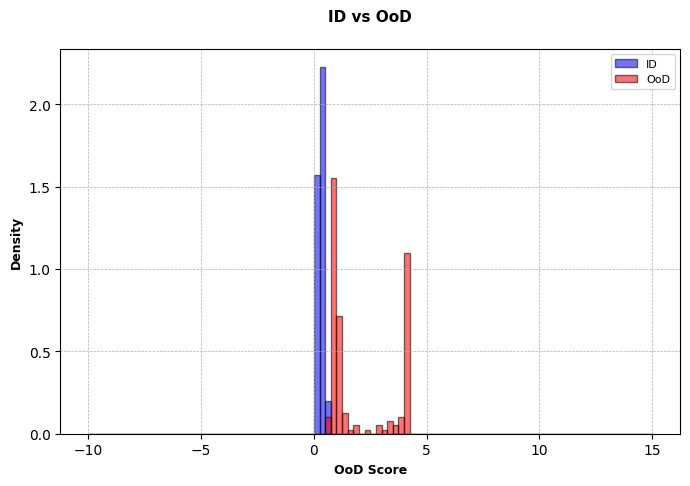

In [1030]:
x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold).dropna(), ['Log_Loss_ALL']]    # ID
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold).dropna(), ['Log_Loss_ALL']]   # OoD


# set range
minRange = np.floor(data_io['Log_Loss_ALL'].min())   # min height - round down
maxRange = np.ceil(data_io['Log_Loss_ALL'].max())    # max height - round up
HRANGE = (minRange-10, maxRange+10)                  # to cover the whole data + padd 10 on either side for display
    
BINS = 100

# plot
plt.figure(figsize=(8,5))
plt.hist(x1, bins=BINS,  range=HRANGE, color='blue', edgecolor='k', alpha = 0.55, label='ID', density=True)
plt.hist(x2, bins=BINS, range=HRANGE, color='red', edgecolor='k', alpha = 0.55, label='OoD', density=True)
plt.grid(lw=.5, ls='--')
plt.title('ID vs OoD', y=1.05, size=11, fontweight='bold')
plt.ylabel('Density', fontsize=9, fontweight='bold')
plt.xlabel('OoD Score', fontsize=9, fontweight='bold')
plt.legend(fontsize=8)    

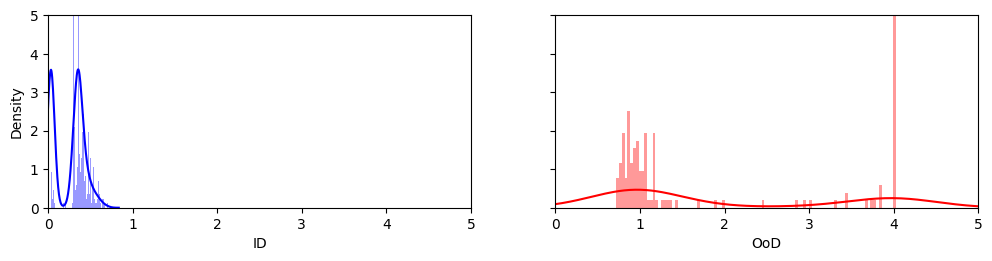

In [1031]:
x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold), ['Log_Loss_ALL']]    # ID
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold), ['Log_Loss_ALL']]   # OoD
vizHist(x1, x2, "ID", "OoD")

## Experiments

In [1032]:
# confusion matrics results for 30 iterations for all experiments
df_CM = pd.DataFrame(columns=['Iter_ID', 'Method', 'Sen_train', 'Spe_train', 'Acc_train', 'Pre_train', 'F1_train', 
                              'Sen_retrain', 'Spe_retrain', 'Acc_retrain', 'Pre_retrain', 'F1_retrain', 
                              'Sen_test', 'Spe_test', 'Acc_test', 'Pre_test', 'F1_test',
                              'train_TN', 'train_FN', 'train_FP', 'train_TP', 
                              'retrain_TN', 'retrain_FN', 'retrain_FP', 'retrain_TP',  
                              'test_TN', 'test_FN', 'test_FP', 'test_TP'])

# sampel counts for training, test1idation, test2 and retrain for 30 iterations
df_Counts = pd.DataFrame(columns=['Iter_ID', 'Method', 'trainSet_nOOD', 'trainSet_OOD', 'reserveSet_nOOD', 'reserveSet_OOD', 
                                   'retrainSet_nOOD', 'retrainSet_OOD', 'testSet_nOOD', 'testSet_OOD'])

df_KLD = pd.DataFrame(columns=['Iter_ID', 'Method', 'Features', 'KLD_t_t', 'KLD_rt_t', 'Types'])


# to identify ood score ranges for ID/OoD samples. ALso capture correctly classified and misclassified
# SampleType - ID or OoD.    TType - training, retraining, testing
df_OodRange = pd.DataFrame(columns=['Iter_ID', 'Method', 'TType', 'SampleType', 'MinOodScore','MaxOodScore'])

# To identify correctly classified and misclassified
#df_CMresults = pd.DataFrame(columns=['Iter_ID', 'Method', 'TType', 'TP','TN', 'FP', 'FN'])

### Baseline - Train - 70% ID, 0% OoD | Test - 30% ID, 30% OoD

In [1033]:
# This code is for experimenting
print("data_io - max = ", str(data_io['Log_Loss_ALL'].max()))

ID_set = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold)] # ID samples
OoD_set = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold)] # OoD samples
bins_plt = jenkspy.jenks_breaks(OoD_set['Log_Loss_ALL'], n_classes=3) 

#topGroup5 = bins_plt[0]  #  lowest value
topGroup4 = bins_plt[0] 
topGroup3 = bins_plt[1] 
topGroup2 = bins_plt[2]  # Highest value
topGroup1 = bins_plt[3]

print("Total N = ", len(data_io))
print("ID Count = ", len(ID_set))
print("OoD Count = ", len(OoD_set))

print("")
print(topGroup1)
print(topGroup2)
print(topGroup3)
print(topGroup4)
#print(topGroup5)

print("   ")
print(OoD_set["Log_Loss_ALL"].max())
print(OoD_set["Log_Loss_ALL"].min())

data_io - max =  4.02317
Total N =  1434
ID Count =  1277
OoD Count =  157

4.02317
3.000315
1.710696
0.719664
   
4.02317
0.719664


In [1034]:
# experimentID 
# total_IDpct - ID samples - split 70 train and 30 test
# total_OoDpct - OoD samples - split 70 reserve and 30 test
# lcl     - top N% to extract from Reserve to add to retraining based on Ood Score grouping

#def assignSample_trainClassifier(experimentID, total_IDpct, total_OoDpct, numIter):

def assignSample_trainClassifier(numIter):
    
    #global gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_retrain_dataF
    
    #print(numIter)
    #-------------------------------------------------------------------------------------------------------------
    # PART-1: CREATE TRAINING, RESERVE and TEST Sets
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Seperate ID and OoD Samples
    # Create training and test sets based on thresholded value
    
    data_io['LogLoss_Group'] = ''  # create a grouping field
    
    gf1Smm_ID_set = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold)] # ID samples
    gf1Smm_OoD_set = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold)] # OoD samples

    # get counts
    gf1Smm_ID_set.shape  # -- ID samples
    gf1Smm_OoD_set.shape  # -- OoD Samles


    # STEP-2: ID Sample allocation for for Training and Testing
    # ID Samples: stratify ID samples by malignancy and manufacturer. Train 70% test 30%
    gf1Smm_ID_set = shuffle(gf1Smm_ID_set) # shuffle ID samples
    #gf1Smm_train_ID, gf1Smm_test_ID = train_test_split(gf1Smm_ID_set, test_size=0.3, stratify=gf1Smm_ID_set[["d_MalignancyDesc", "Manufacturer"]])
    gf1Smm_train_ID, gf1Smm_test_ID = train_test_split(gf1Smm_ID_set, test_size=0.3, stratify=gf1Smm_ID_set[["d_MalignancyDesc"]])
        

    
    # STEP-3: OoD Sample allocation for Reserve and Test - gf1Smm_OoD_set is OoD samples
    # OoD Samples: Group log loss value to groups for stratification add top G%

    #n_plt, bins_plt, patches = plt.hist(gf1Smm_OoD_set.Log_Loss_ALL, bins=4) # BASED ON HISTOGRAM
    bins_plt = jenkspy.jenks_breaks(gf1Smm_OoD_set['Log_Loss_ALL'], n_classes=3) # based on natural breaks

    topGroup4 = bins_plt[0]  # top group 4 - lowest value
    topGroup3 = bins_plt[1]  # top group 3
    topGroup2 = bins_plt[2]  # top group 2
    topGroup1 = bins_plt[3]  # top group 1 - Highest value

    # update group based on lower bound
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[1])) , "LogLoss_Group"] = bins_plt[0]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[1]) & (gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[2])) , "LogLoss_Group"] = bins_plt[1]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[2]) & (gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[3])) , "LogLoss_Group"] = bins_plt[2]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[3])) , "LogLoss_Group"] = bins_plt[3]

    # OoD Samples: stratify OoD samples by malignancy ood score grouping and manufacturer. Train 70% test 30%
    gf1Smm_OoD_set = shuffle(gf1Smm_OoD_set) # shuffle ID samples
    gf1Smm_reserve_OOD, gf1Smm_test_OOD = train_test_split(gf1Smm_OoD_set, test_size=0.3, stratify=gf1Smm_OoD_set[["d_MalignancyDesc", "LogLoss_Group"]])

    
    gf1Smm_train_dataF = gf1Smm_train_ID
    gf1Smm_reserve_dataF = gf1Smm_reserve_OOD
    gf1Smm_test_dataF = pd.concat([gf1Smm_test_ID, gf1Smm_test_OOD])
    
    
    
    #-------------------------------------------------------------------------------------------------------------
    # PART-2: TRAIN RF CLASSIFIER
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: # Select fields to use based on training set - IMPORTANT

    # I/P features: Design Features and SF, Manufacturer - added based on correlation values
    cols=['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation', 'Compactness', 
          'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency', 'MaxProbability', 
          'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1', 
          'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1', 
          'dManuf_GE', 'dManuf_S', 'dManuf_P'] 


    gf1SmmX_train = gf1Smm_train_dataF[cols]
    gf1Smmy_train = gf1Smm_train_dataF['d_Malignancy']

    gf1SmmX_reserve = gf1Smm_reserve_dataF[cols]
    gf1Smmy_reserve = gf1Smm_reserve_dataF['d_Malignancy']  

    gf1SmmX_test = gf1Smm_test_dataF[cols]
    gf1Smmy_test = gf1Smm_test_dataF['d_Malignancy'] 


    # STEP-2: Train Classifier and fit the classifier
    
    # cost: 
    mCountA = len(data_io[data_io['d_Malignancy']== 1])
    bCountA = len(data_io[data_io['d_Malignancy']== 0])
    IR      = mCountA/bCountA
    
    rfExp_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                              class_weight = {0: IR, 1: 1.5},
                                               max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                               n_jobs=-1, random_state=42)


    # Assuming you have already defined and imported the measure_performance function

# Measure the performance of rfExp_classifier.fit()
    # Measure the performance of rfExp_classifier.fit()
    trained_model, training_time, cpu_usage, memory_usage = measure_performance(rfExp_classifier.fit, gf1SmmX_train, gf1Smmy_train)

    print("Training time:", training_time, "seconds")
    print("CPU usage:", cpu_usage, "%")
    print("Memory usage:", memory_usage, "bytes")
 


    # get terminal node
    #getLeafCount(rfExp_classifier, 'tree_2kA1_10_0.dot')
    

    
    #-------------------------------------------------------------------------------------------------------------
    # PART-3: EVALUATE TRAINING, TEST PERFORMANCE
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Obtain Threshold using Training set for GMeans method

    # calculate roc curves - Thresold based on Training
    precision_f1Smm, recall_f1Smm, thresholds_pr_f1Smm = precision_recall_curve(gf1Smmy_train, rfExp_classifier.predict_proba(gf1Smm_train_dataF[gf1SmmX_train.columns])[:,1])
    
    # Calculate the f-score
    fscore_f1Smm = (2 * precision_f1Smm * recall_f1Smm) / (precision_f1Smm + recall_f1Smm)

    # Find the optimal threshold
    index_pr_f1Smm = np.argmax(fscore_f1Smm)
    gf1Smm_trainThreshold = round(thresholds_pr_f1Smm[index_pr_f1Smm], ndigits = 4)
    
    

    # STEP-2: Compute predicted Probabilities - first round (based on training)
    gf1Smm_train_dataF['Pred_prob1']   = rfExp_classifier.predict_proba(gf1Smm_train_dataF[gf1SmmX_train.columns])[:,1]
    gf1Smm_reserve_dataF['Pred_prob1'] = rfExp_classifier.predict_proba(gf1Smm_reserve_dataF[gf1SmmX_reserve.columns])[:,1]
    gf1Smm_test_dataF['Pred_prob1']    = rfExp_classifier.predict_proba(gf1Smm_test_dataF[gf1SmmX_test.columns])[:,1] 
    

    # STEP-3: Compute Pred_Y based on the predicted probability and threshold
    #         if pred Pred_prob >= threshold, then Pred_Y = 1, else 0

    T = gf1Smm_trainThreshold
    #print("Train Threshold = ", str(T))

    # Train - compute Pred_Y
    gf1Smm_train_dataF["Pred_Y1"] = 0
    gf1Smm_train_dataF.loc[gf1Smm_train_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1

    # Reserve - compute Pred_Y
    gf1Smm_reserve_dataF["Pred_Y1"] = 0
    gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1

    # Tests - compute Pred_Y
    gf1Smm_test_dataF["Pred_Y1"] = 0
    gf1Smm_test_dataF.loc[gf1Smm_test_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1


    # check if the variables were created and populated correctly
    gf1Smm_train_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)
    gf1Smm_reserve_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)
    gf1Smm_test_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)


    # Step-4: Confusion matrix for training and test set
    # funcation to compute and return values for - training and test performance
    Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP = confMatrixResults(gf1Smm_train_dataF.d_Malignancy, gf1Smm_train_dataF.Pred_Y1)
    Sen_gf1Smm_test, Spe_gf1Smm_test, Acc_gf1Smm_test, Pre_gf1Smm_test, F1_gf1Smm_test, test_TN, test_FN, test_FP, test_TP = confMatrixResults(gf1Smm_test_dataF.d_Malignancy, gf1Smm_test_dataF.Pred_Y1)  
    
    
    
    # train, reserve, test samples, last 2 for counts
    return gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP

In [1035]:

def createRetrainSet(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, 
                      topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, 
                      gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP, 
                      numIter):

    #print(topGroup1, topGroup2, topGroup3, topGroup4)
    #print("itemID --- createRetrainSet = ", str(numIter))
    
    #-------------------------------------------------------------------------------------------------------------
    # PART-4: Create retraining sample and retrain classifier based on OoD Score group
    #-------------------------------------------------------------------------------------------------------------

    # SETP-1: Extract the OOD Samples from test1 Set Added to Training
    
    # TOP GROUP 0 
    # Add top group first topGroup1
    experimentID = 'Experiment1_0'
    
    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] < topGroup4] # on OODs
    gf1Smm_oodSamples_toAdd.shape
    #gf1Smm_reserve_dataF.to_csv("reserve.csv")

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, 
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, 
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_x.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")
    
    # Distribution
    x1 = gf1Smm_train_dataF.loc[(gf1Smm_train_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Train
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]      # Test
    vizHist(x1, x2, "Train", "Test")
    vizHist2(x1, x2, "Train", "Test")
    
    

    # TOP GROUP 1 
    # Add top group first topGroup1
    experimentID = 'Experiment1_1'
    
    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup3]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, 
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, 
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_1.dot')
    
    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")

    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-1", "Test")
    vizHist2(x1, x2, "Retrain-1", "Test")
    
    

    # TOP GROUP 2 
    # Add top group first topGroup2
    experimentID = 'Experiment1_2'
    
    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup2]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, 
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, 
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_2.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")


    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-2", "Test")
    vizHist2(x1, x2, "Retrain-2", "Test")
    
    
    
    # TOP GROUP 3 
    # Add top group first topGroup3
    experimentID = 'Experiment1_3'
    
    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup1]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, 
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, 
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_3.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")


    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-3", "Test")   
    vizHist2(x1, x2, "Retrain-3", "Test") 
           

In [1036]:

def retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, 
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, 
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, 
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, tree_fileName):
    
    global df_CM, df_Counts, df_KLD, df_OodRange, df_RetrainOoD

 
    #-------------------------------------------------------------------------------------------------------------
    # PART-5: Retraining Classifier 
    #-------------------------------------------------------------------------------------------------------------
    
    # STEP-1: Fit the model
    # set columns for retraining model. Feature list is same as original/full training model
    
    cols=['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation', 'Compactness', 
          'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency', 'MaxProbability', 
          'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1', 
          'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1', 
          'dManuf_GE', 'dManuf_S', 'dManuf_P'] 
        
        
    gf1SmmX_retrain = gf1Smm_retrain_dataF[cols]
    gf1Smmy_retrain = gf1Smm_retrain_dataF['d_Malignancy']
    
       

    # retrain classifier and fit the classifier
  
    # cost: 
    mCountA = len(data_io[data_io['d_Malignancy']== 1])
    bCountA = len(data_io[data_io['d_Malignancy']== 0])
    IR      = mCountA/bCountA
    
    rfExp_reTrain_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                                      class_weight = {0: IR, 1: 1.5},
                                                       max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                                       n_jobs=-1, random_state=42)

    # Assuming you have already defined and imported the measure_performance function

    # Measure the performance of rfExp_reTrain_classifier.fit()
    trained_model, training_time, cpu_usage, memory_usage = measure_performance(rfExp_reTrain_classifier.fit, gf1SmmX_retrain, gf1Smmy_retrain)

    print("Retraining time:", training_time, "seconds")
    print("Re-CPU usage:", cpu_usage, "%")
    print("Re-Memory usage:", memory_usage, "bytes")



    # get terminal node
    #getLeafCount(rfExp_reTrain_classifier, tree_fileName)

    
    # STEP-2: Write Counts for Training, reserve, test Set Counts to dataframe
    nOOD_Train  = len(gf1Smm_train_dataF)
    OOD_Train   = 0
    nOOD_reserve  = 0
    OOD_reserve   = len(gf1Smm_reserve_dataF)
    nOOD_test  = len(gf1Smm_test_ID)
    OOD_test   = len(gf1Smm_test_OOD)
    nOODRetrain = nOOD_Train 
    OOD_Retrain = len(gf1Smm_oodSamples_toAdd)


    df_Counts = df_Counts.append({'Iter_ID': numIter , 'Method': experimentID, 
                                   'trainSet_nOOD': nOOD_Train ,  'trainSet_OOD': OOD_Train, 
                                   'reserveSet_nOOD': nOOD_reserve , 'reserveSet_OOD': OOD_reserve , 
                                   'retrainSet_nOOD': nOODRetrain , 'retrainSet_OOD': OOD_Retrain , 
                                   'testSet_nOOD': nOOD_test , 'testSet_OOD': OOD_test }, ignore_index=True)

    
    # Step-3: Get OoD Score ranges for ID and OoD Samples for each experiment
    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID, 
                                      'TType': 'Train', 'SampleType': 'ID', 
                                      'MinOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].max() }, ignore_index=True)

    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID, 
                                      'TType': 'Retrain', 'SampleType': 'ID', 
                                      'MinOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].max() }, ignore_index=True)
    
    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID, 
                                      'TType': 'Retrain', 'SampleType': 'OOD', 
                                      'MinOodScore': gf1Smm_oodSamples_toAdd['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_oodSamples_toAdd['Log_Loss_ALL'].max() }, ignore_index=True) 
    
    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID, 
                                      'TType': 'Test', 'SampleType': 'ID', 
                                      'MinOodScore': gf1Smm_test_ID['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_test_ID['Log_Loss_ALL'].max() }, ignore_index=True)
    
    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID, 
                                      'TType': 'Test', 'SampleType': 'OOD', 
                                      'MinOodScore': gf1Smm_test_OOD['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_test_OOD['Log_Loss_ALL'].max() }, ignore_index=True)  
 
    
    #-------------------------------------------------------------------------------------------------------------
    # PART-6: Retraining Classifier - Compute performance on retraining and test sets
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Compute predicted probabilities

    gf1Smm_retrain_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_retrain_dataF[gf1SmmX_retrain.columns])[:,1]
    gf1Smm_reserve_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_reserve_dataF[gf1SmmX_reserve.columns])[:,1]
    gf1Smm_test_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_test_dataF[gf1SmmX_test.columns])[:,1]

    # calculate roc curves - Thresold based on Training
    precision_retrainf1Smm, recall_retrainf1Smm, thresholds_pr_retrainf1Smm = precision_recall_curve(gf1Smmy_retrain, rfExp_reTrain_classifier.predict_proba(gf1Smm_retrain_dataF[gf1SmmX_retrain.columns])[:,1])

    # Calculate the f-score
    fscore_retrainf1Smm = (2 * precision_retrainf1Smm * recall_retrainf1Smm) / (precision_retrainf1Smm + recall_retrainf1Smm)

    # Find the optimal threshold
    index_pr_retrainf1Smm = np.argmax(fscore_retrainf1Smm)
    gf1Smm_retrainThreshold = round(thresholds_pr_retrainf1Smm[index_pr_retrainf1Smm], ndigits = 4)
    
    
    
    T_new = gf1Smm_retrainThreshold
    #print("Retrain Threshold = ", str(T_new), " for ", str(experimentID))


    # Step-2: Retrain - compute Pred_Y
    gf1Smm_retrain_dataF["Pred_Y2"] = 0
    gf1Smm_retrain_dataF.loc[gf1Smm_retrain_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1

    # test - compute Pred_Y
    gf1Smm_test_dataF["Pred_Y2"] = 0
    gf1Smm_test_dataF.loc[gf1Smm_test_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1


    # Reserve - compute Pred_Y --- DONE FOR Reserve SO THAT COLUMNS ARE IN THE SAME ORDER FOR ALL 3 SETS
    gf1Smm_reserve_dataF["Pred_Y2"] = 0
    gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1
    
    
    # Export to excel for checking misclassifications
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Train_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_train_dataF.to_csv(myPath)
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Retrain_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_retrain_dataF.to_csv(myPath)
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Test_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_test_dataF.to_csv(myPath)


    # Step-3: Confusion matrix for retraining and test2 set
    # funcation to compute and return test1ues  retrain and test2 
    Sen_gf1Smm_retrain, Spe_gf1Smm_retrain, Acc_gf1Smm_retrain, Pre_gf1Smm_retrain, F1_gf1Smm_retrain,  retrain_TN, retrain_FN, retrain_FP, retrain_TP  = confMatrixResults(gf1Smm_retrain_dataF.d_Malignancy, gf1Smm_retrain_dataF.Pred_Y2)
    Sen_gf1Smm_test, Spe_gf1Smm_test, Acc_gf1Smm_test, Pre_gf1Smm_test, F1_gf1Smm_test, test_TN, test_FN, test_FP, test_TP  = confMatrixResults(gf1Smm_test_dataF.d_Malignancy, gf1Smm_test_dataF.Pred_Y2)


    #-------------------------------------------------------------------------------------------------------------
    # PART-7: Write all performance indicators to dataframe. Compute Average and CI
    #         Note: only step-1 variable list needs to be changed
    #-------------------------------------------------------------------------------------------------------------

    # Step-1: write results to dataframe
    df_CM = df_CM.append({'Iter_ID': numIter , 'Method': experimentID, 
                              'Sen_train': Sen_gf1Smm_train , 'Spe_train': Spe_gf1Smm_train , 'Acc_train': Acc_gf1Smm_train , 
                              'Pre_train': Pre_gf1Smm_train , 'F1_train': F1_gf1Smm_train,
                              'Sen_retrain': Sen_gf1Smm_retrain , 'Spe_retrain': Spe_gf1Smm_retrain , 'Acc_retrain': Acc_gf1Smm_retrain , 
                              'Pre_retrain': Pre_gf1Smm_retrain , 'F1_retrain' : F1_gf1Smm_retrain,
                              'Sen_test': Sen_gf1Smm_test , 'Spe_test': Spe_gf1Smm_test , 'Acc_test': Acc_gf1Smm_test , 
                              'Pre_test': Pre_gf1Smm_test , 'F1_test': F1_gf1Smm_test,
                              'train_TN' : train_TN, 'train_FN': train_FN, 'train_FP': train_FP, 'train_TP': train_TP, 
                              'retrain_TN': retrain_TN, 'retrain_FN':retrain_FN, 'retrain_FP':retrain_FP, 'retrain_TP': retrain_TP,  
                              'test_TN': test_TN, 'test_FN': test_FN, 'test_FP': test_FP, 'test_TP': test_TP }, ignore_index=True)


    #return gf1Smm_retrain_dataF

Training time: 0.10386490821838379 seconds
CPU usage: 65.60000000000001 %
Memory usage: 7454720 bytes
Retraining time: 0.07508707046508789 seconds
Re-CPU usage: 27.1 %
Re-Memory usage: 507904 bytes
Retraining time: 0.2261028289794922 seconds
Re-CPU usage: 0.0 %
Re-Memory usage: -1622016 bytes
Retraining time: 0.1967182159423828 seconds
Re-CPU usage: 31.80000000000001 %
Re-Memory usage: 3653632 bytes
Retraining time: 0.17262005805969238 seconds
Re-CPU usage: 31.89999999999999 %
Re-Memory usage: 0 bytes
Training time: 0.17029690742492676 seconds
CPU usage: 39.0 %
Memory usage: 425984 bytes
Retraining time: 0.07447504997253418 seconds
Re-CPU usage: 29.900000000000002 %
Re-Memory usage: 0 bytes
Retraining time: 0.21111512184143066 seconds
Re-CPU usage: 0.0 %
Re-Memory usage: 0 bytes
Retraining time: 0.1902790069580078 seconds
Re-CPU usage: 41.39999999999999 %
Re-Memory usage: 16384 bytes
Retraining time: 0.18950700759887695 seconds
Re-CPU usage: 45.099999999999994 %
Re-Memory usage: 557056

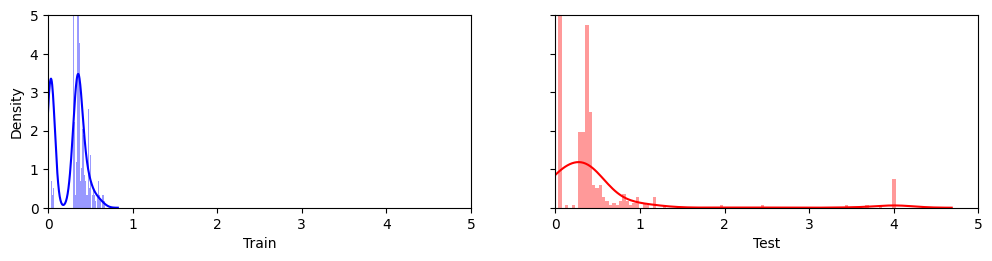

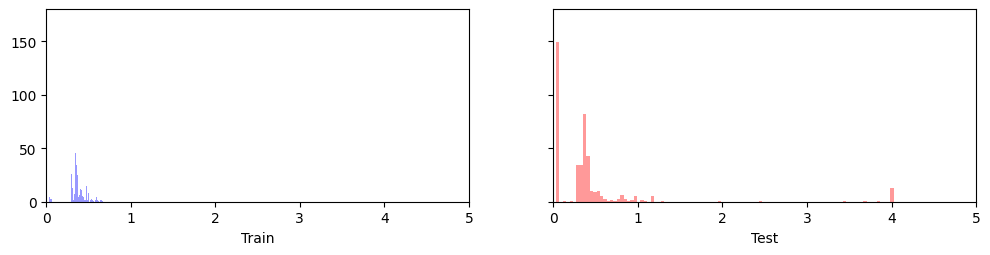

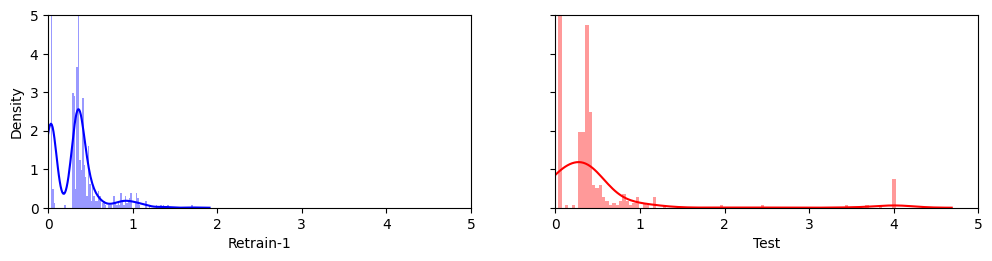

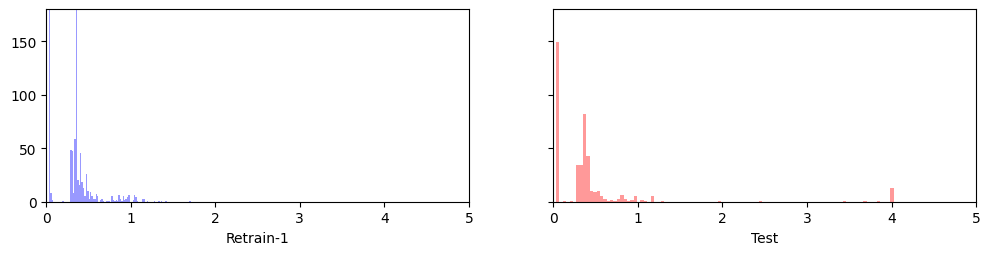

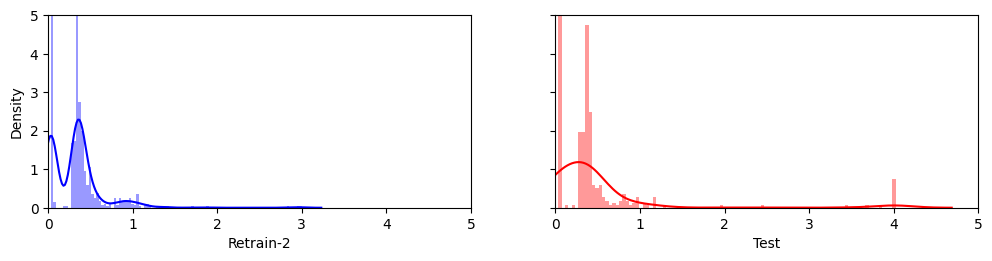

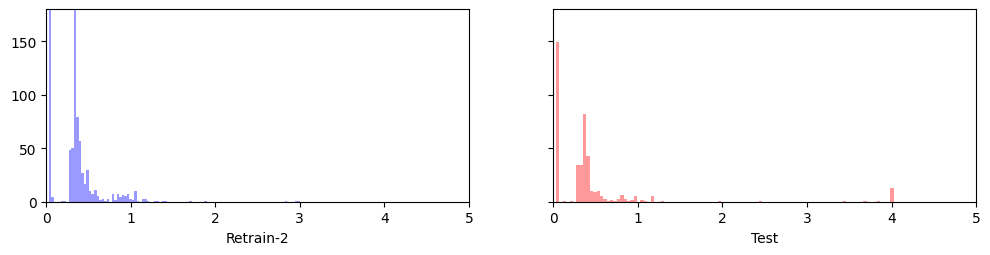

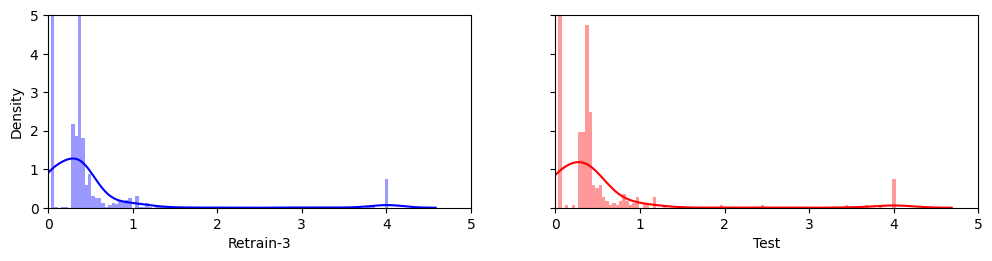

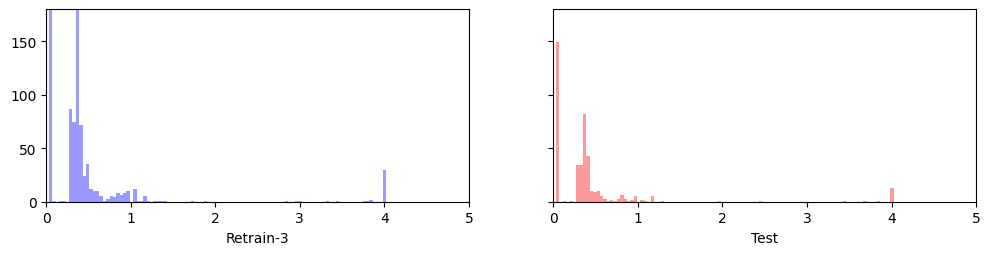

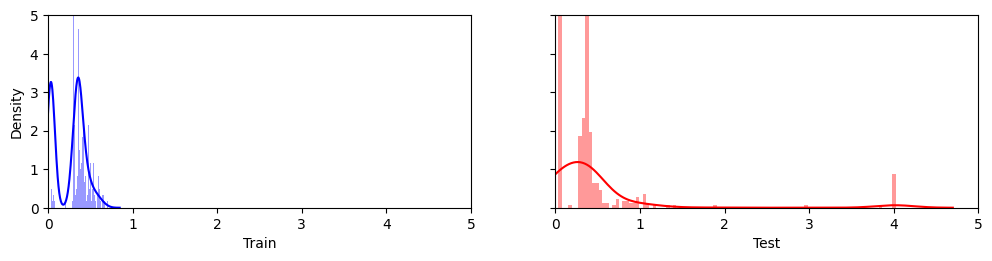

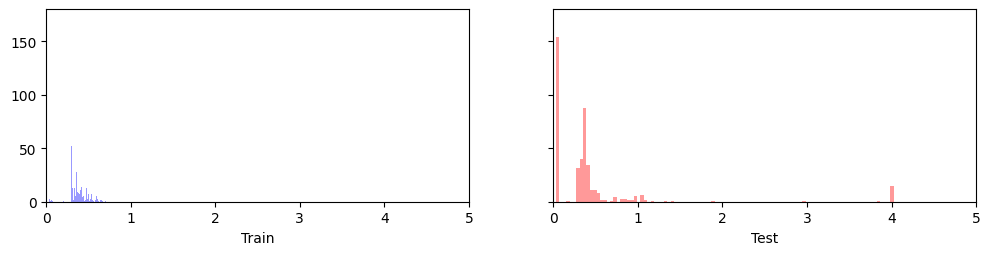

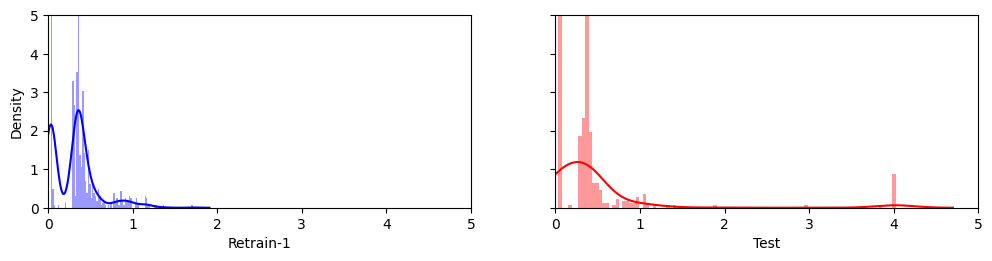

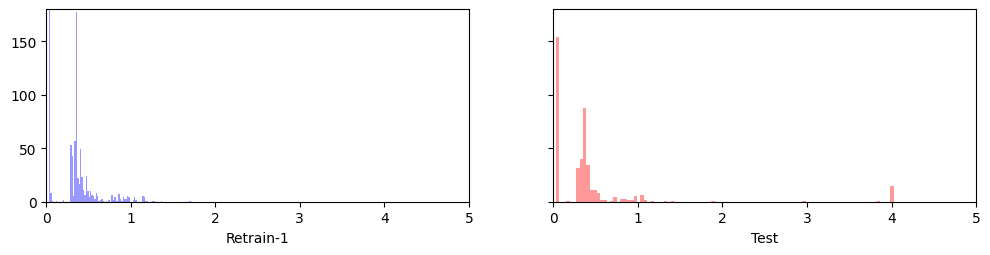

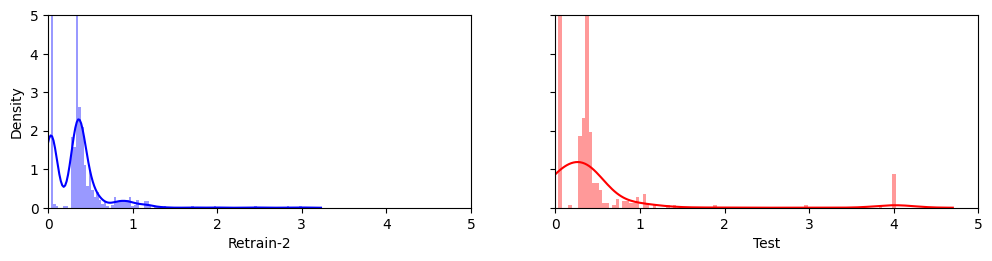

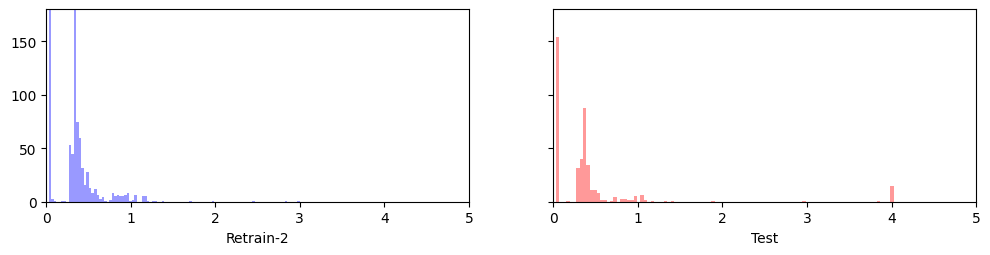

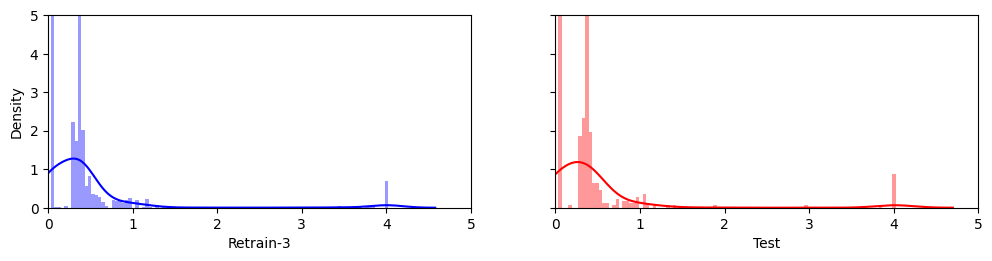

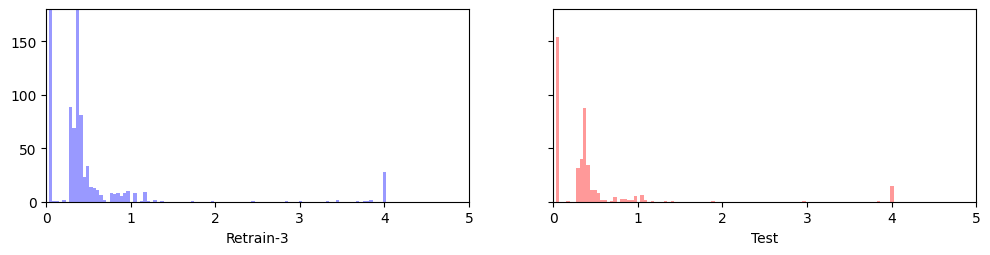

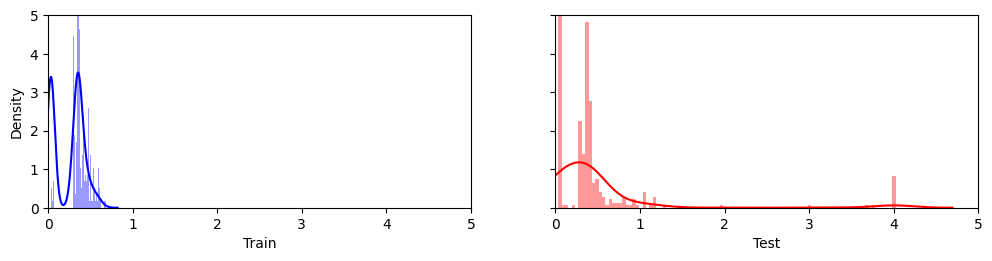

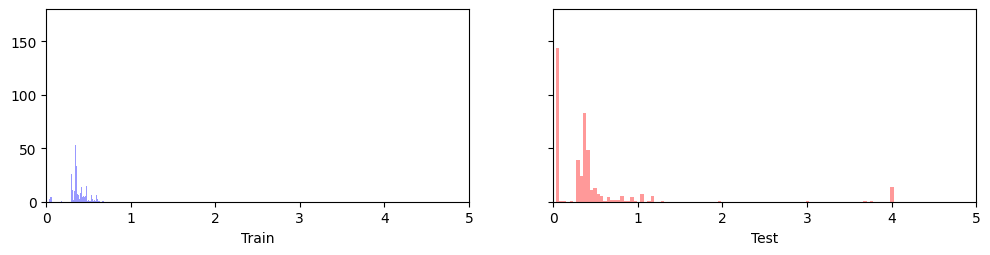

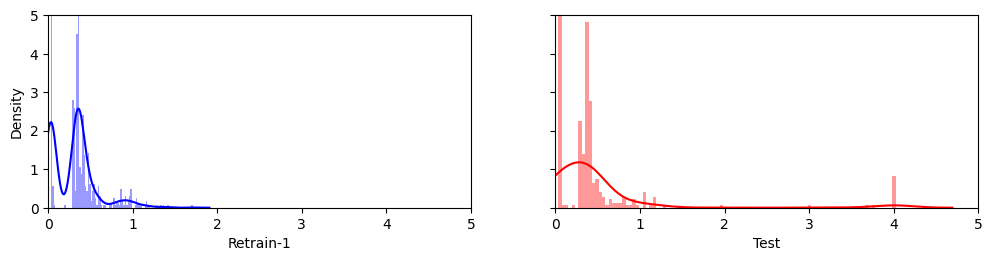

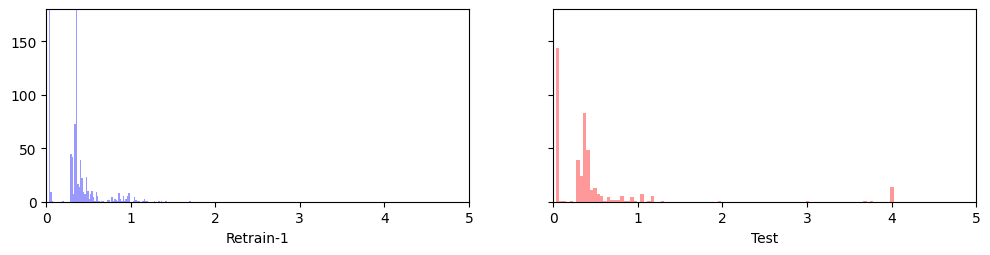

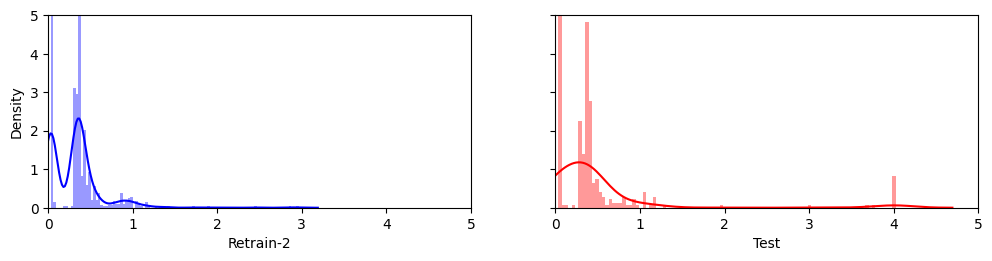

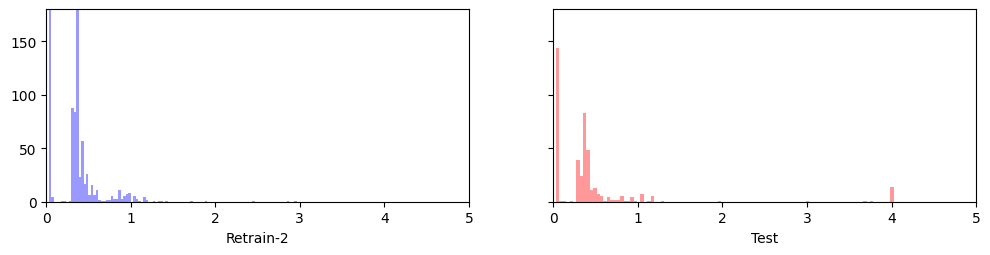

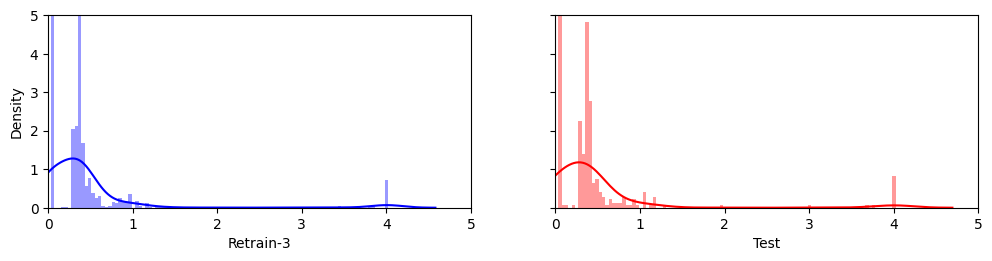

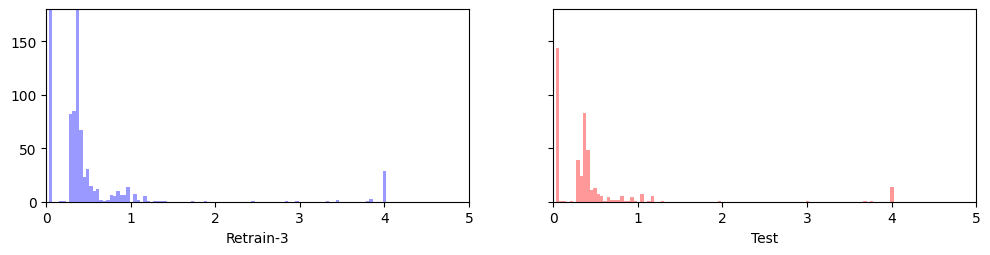

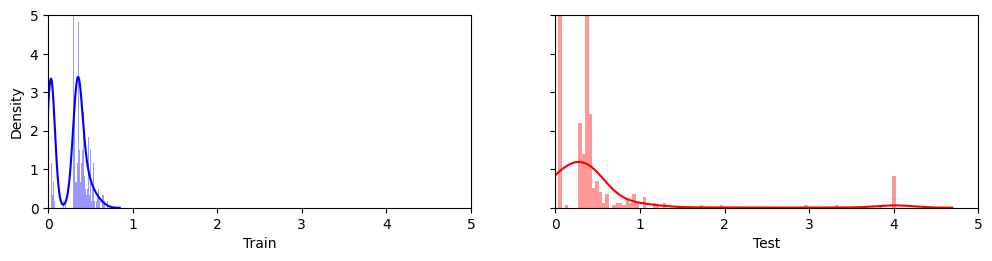

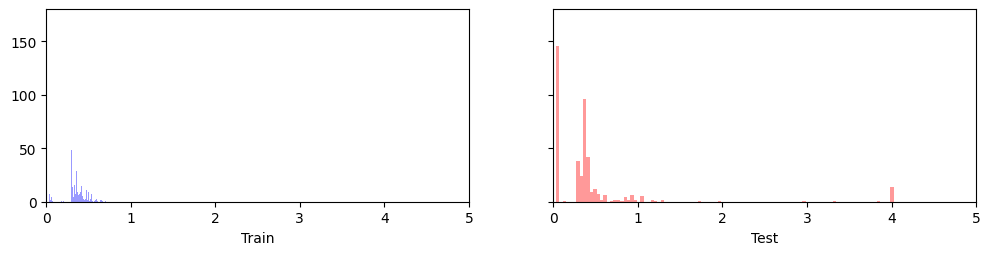

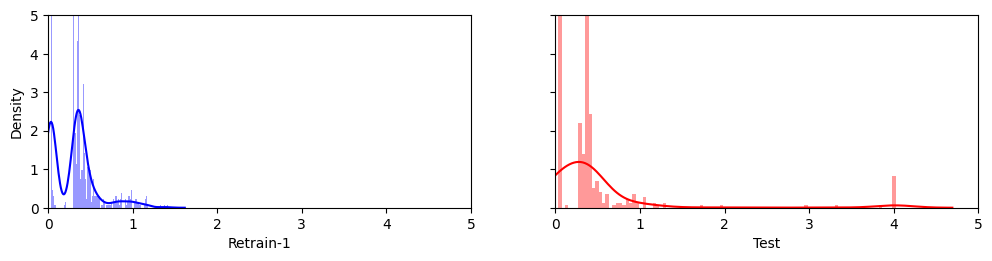

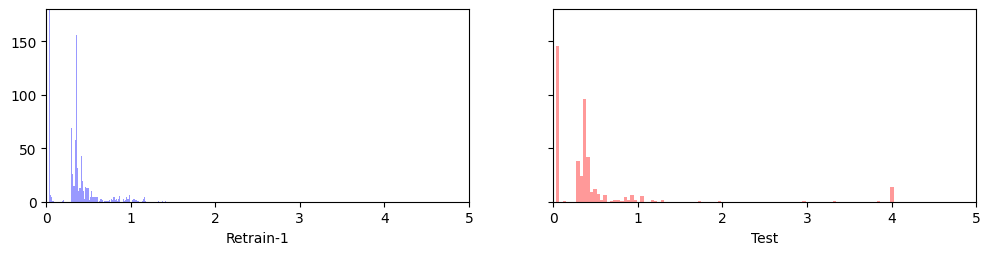

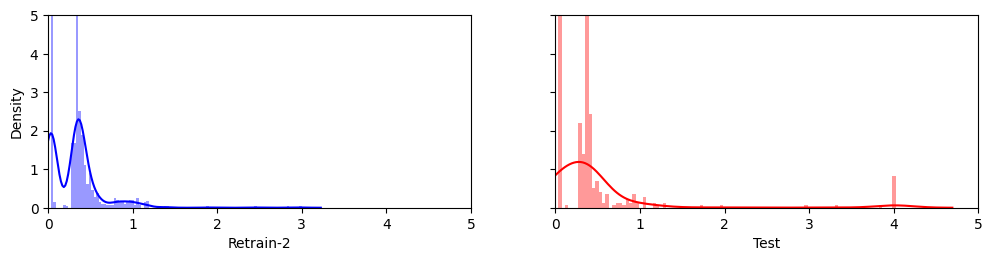

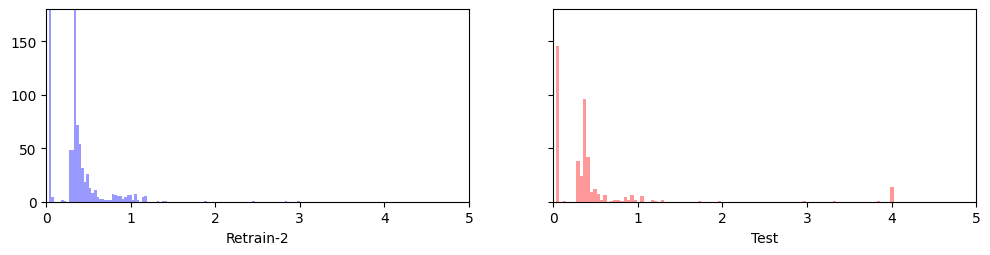

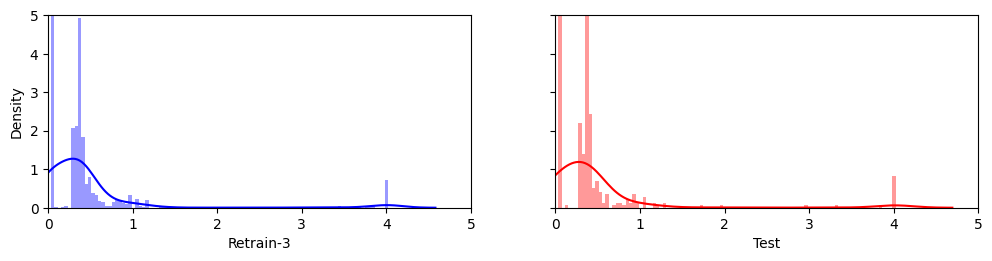

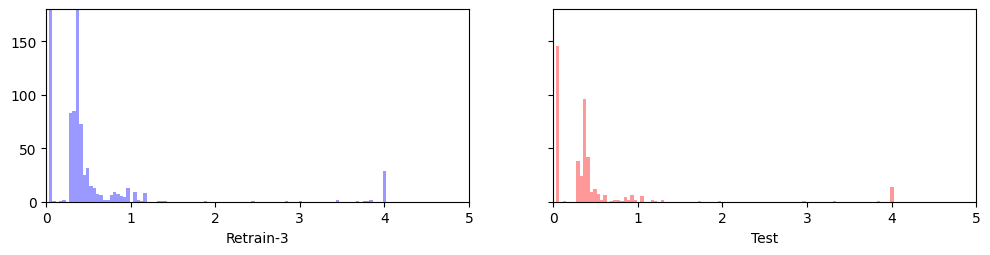

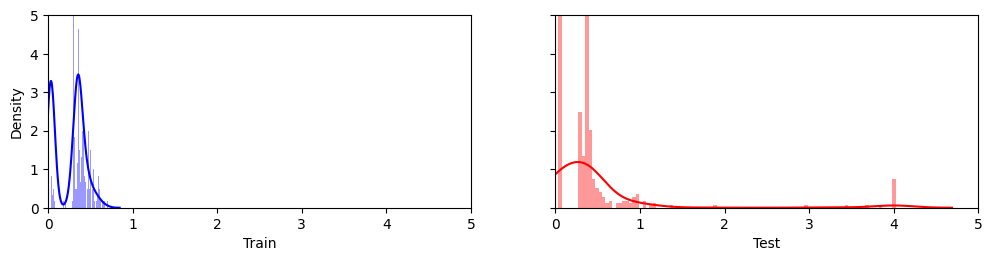

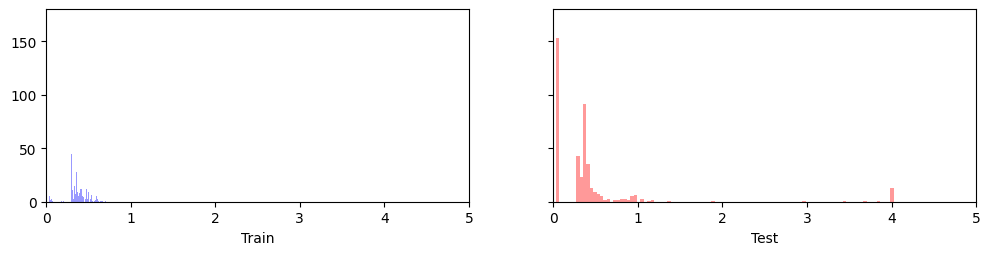

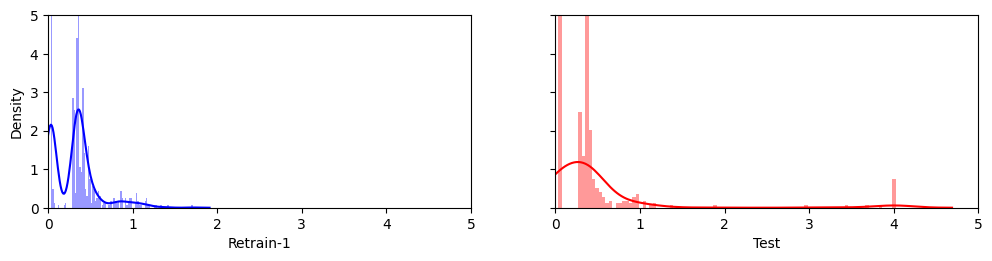

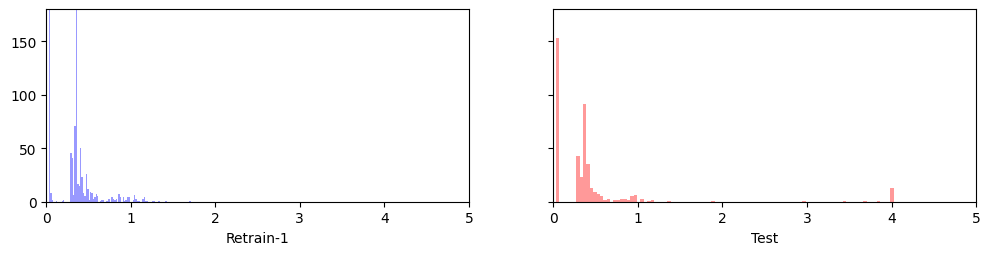

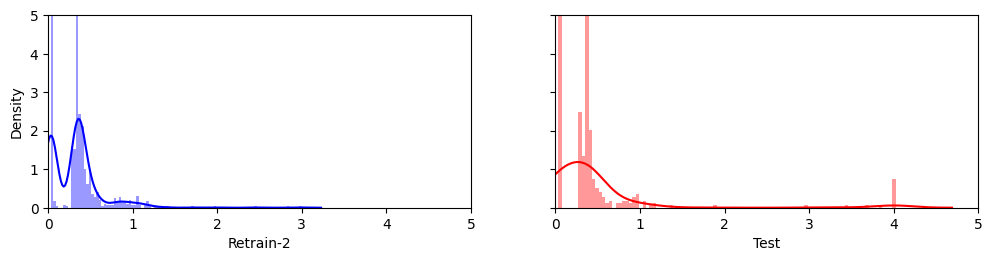

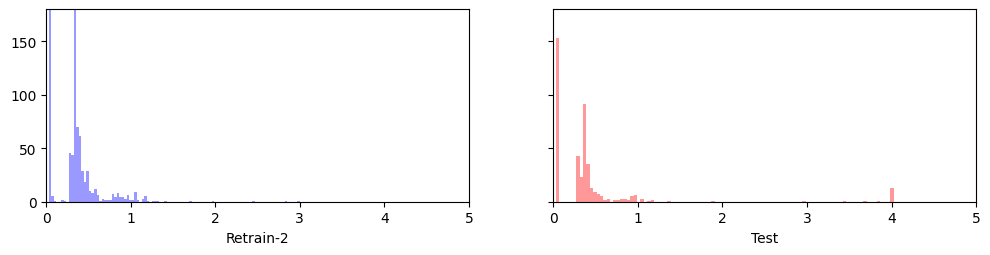

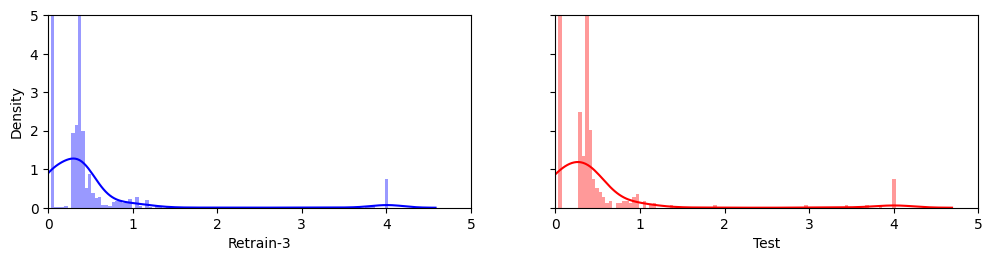

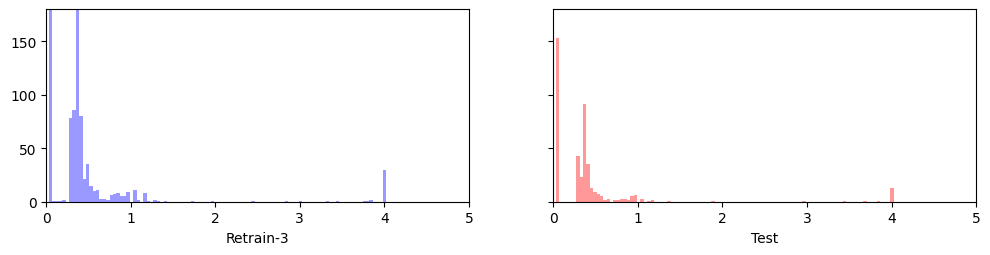

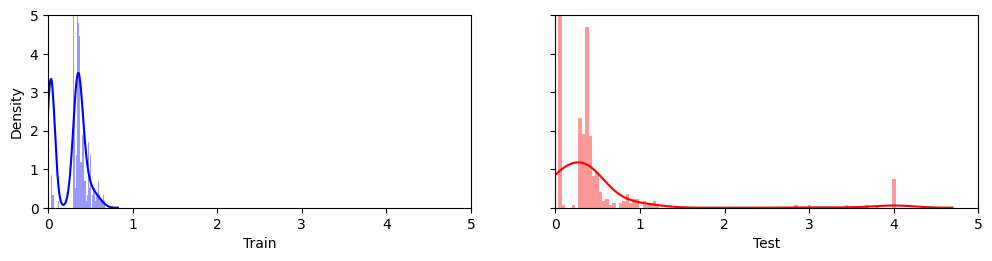

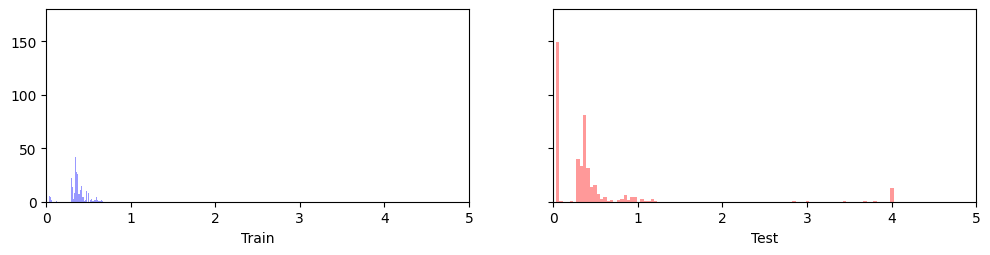

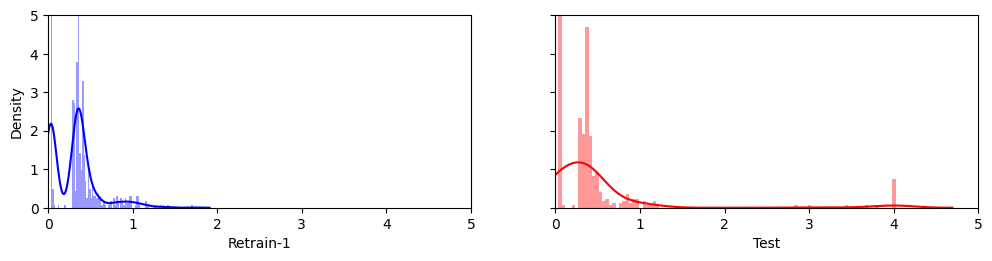

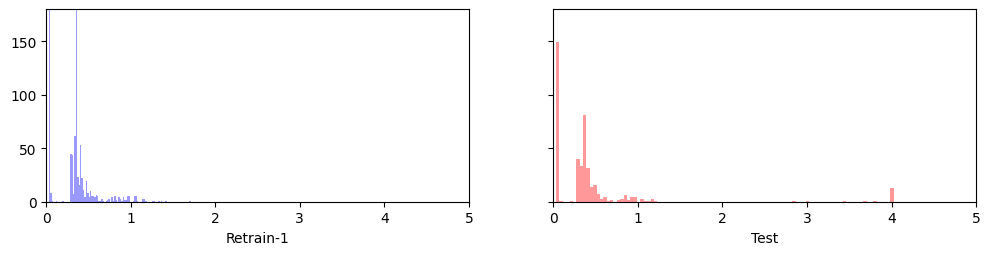

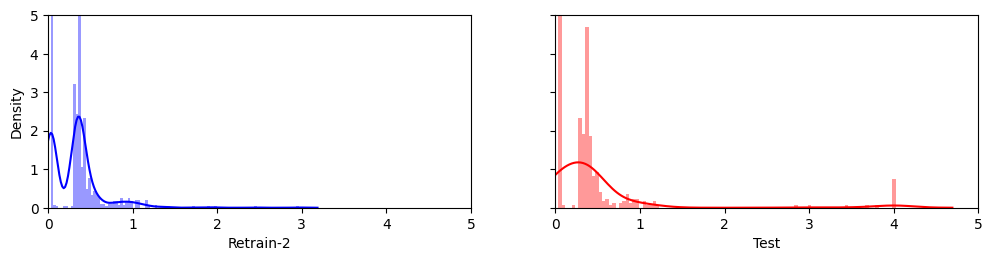

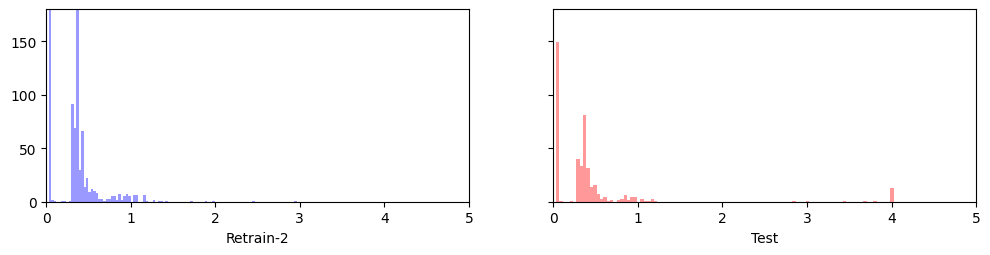

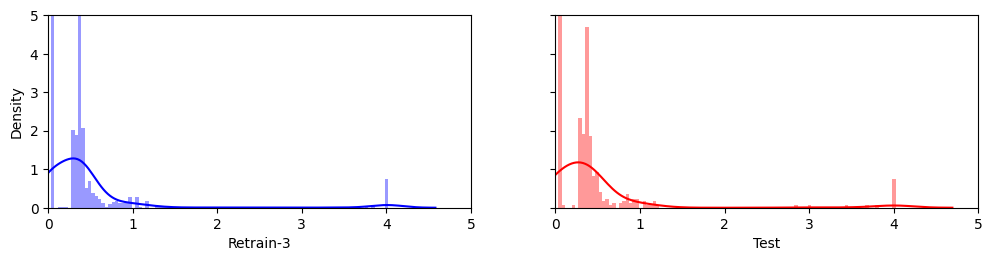

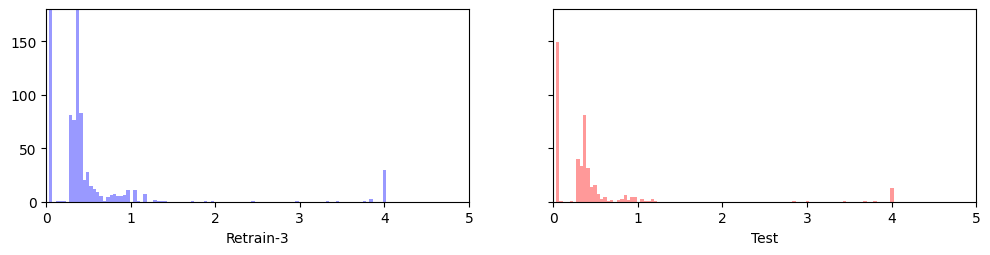

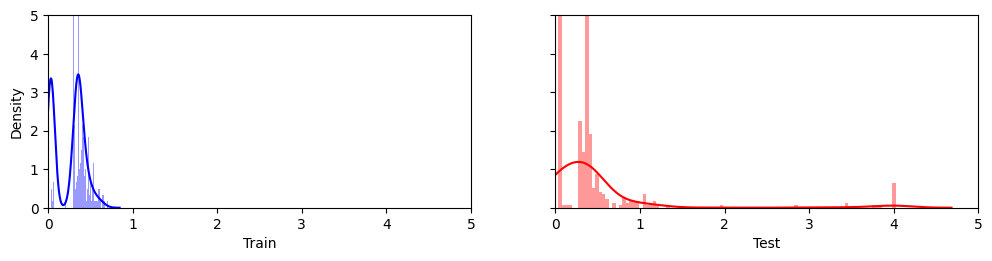

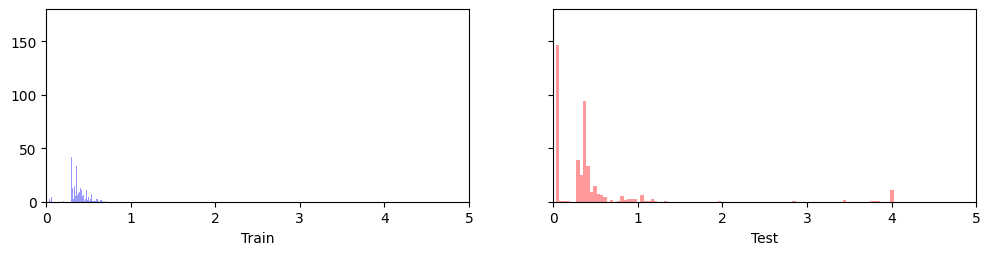

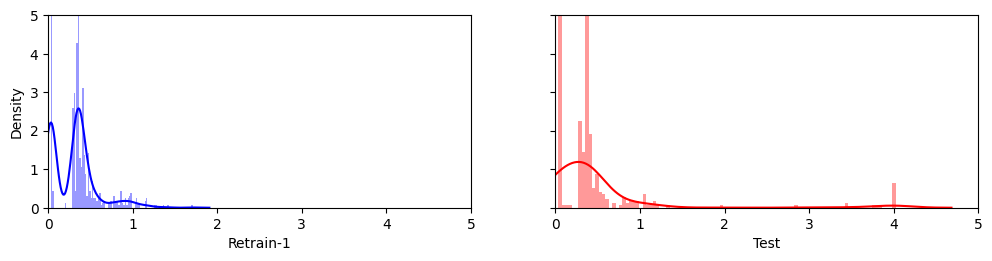

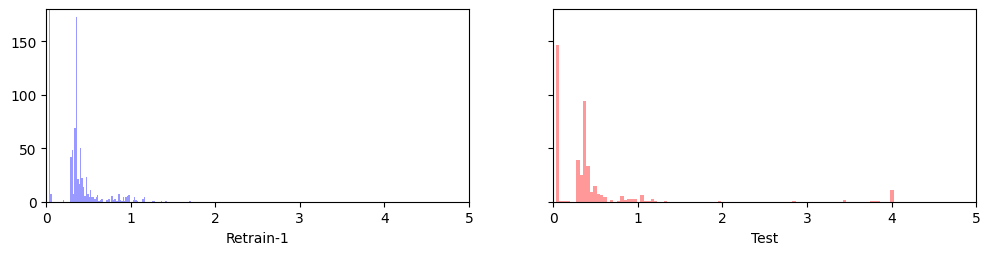

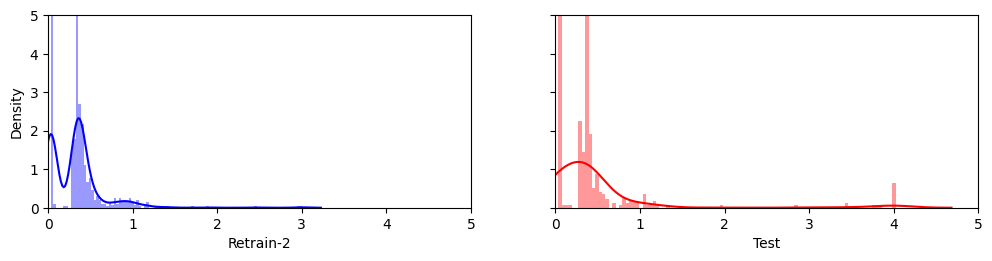

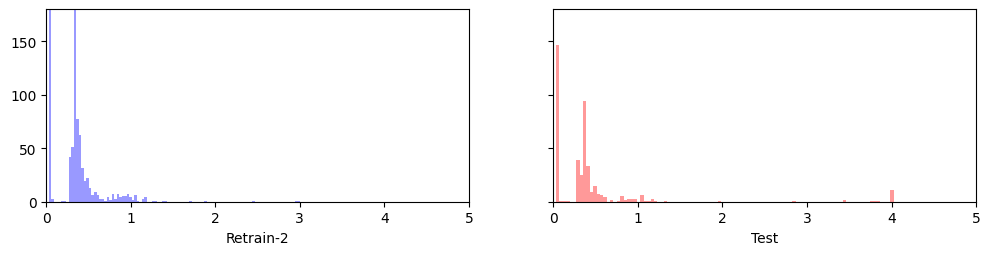

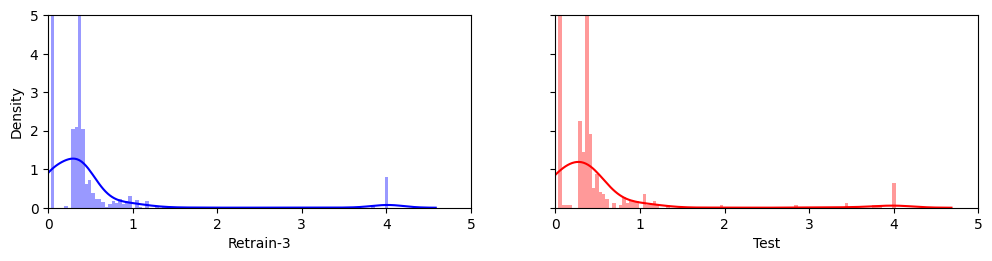

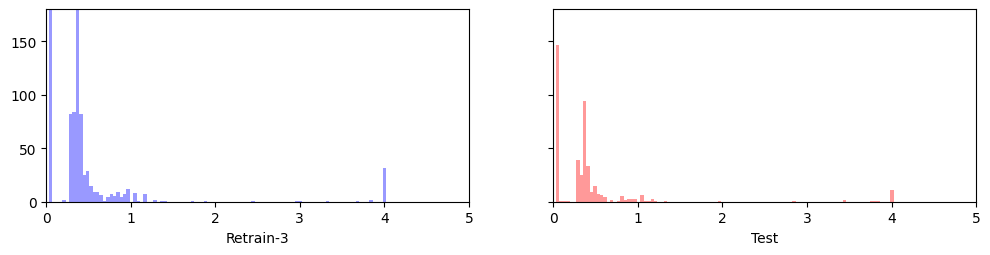

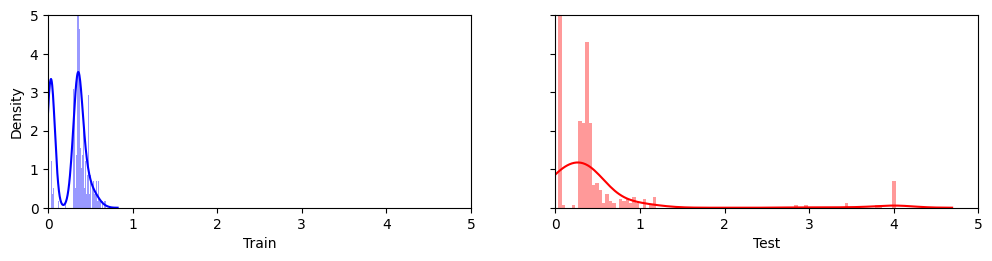

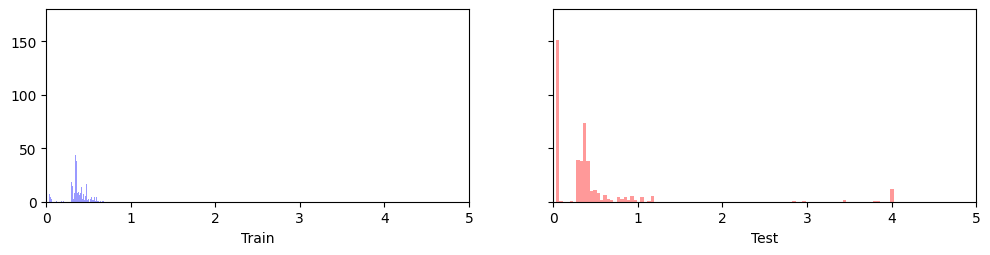

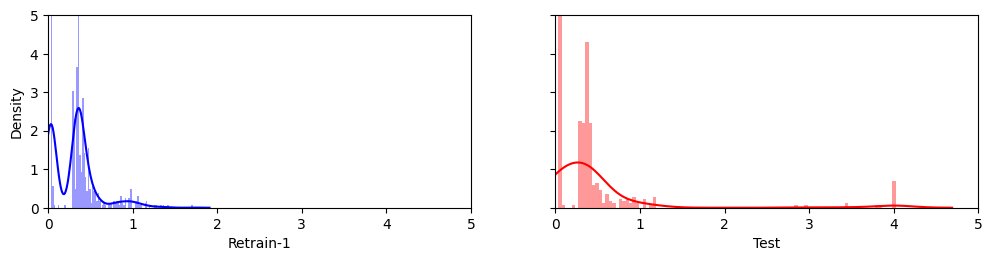

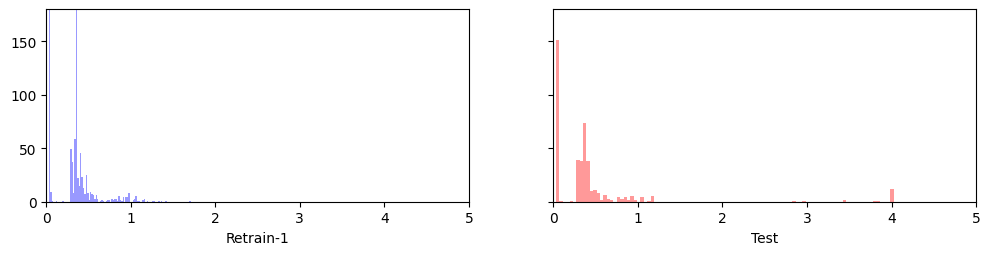

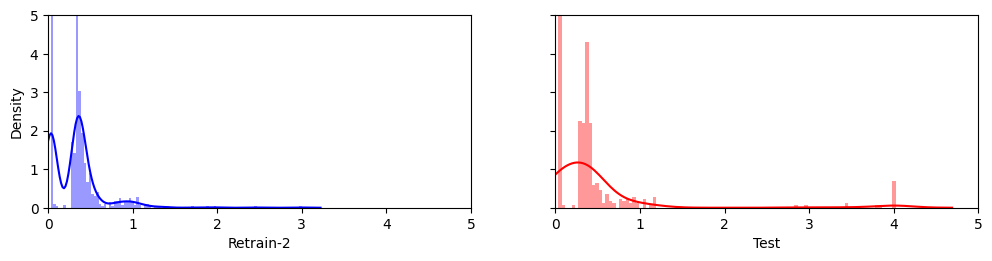

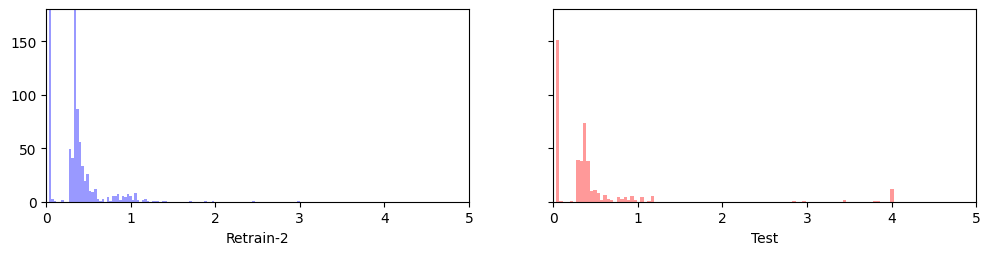

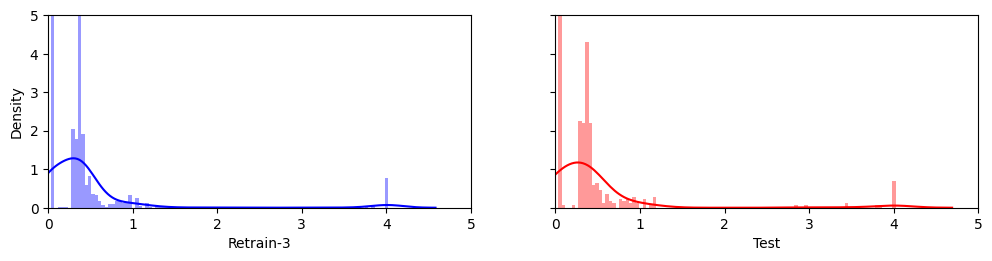

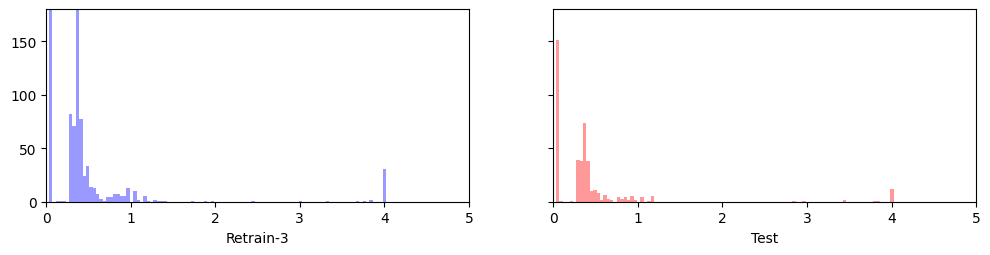

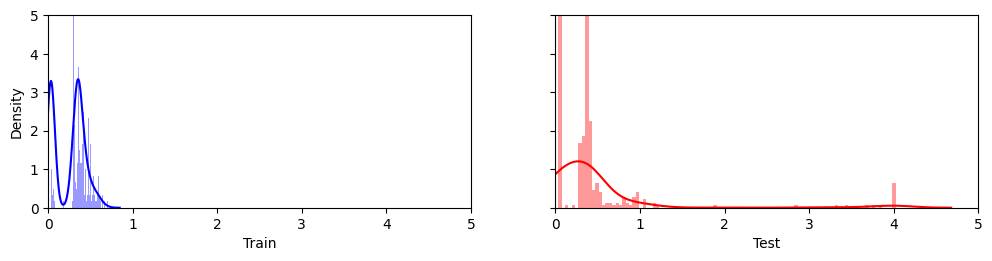

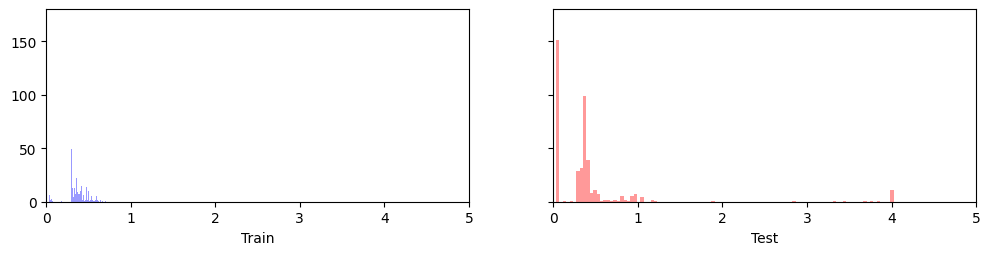

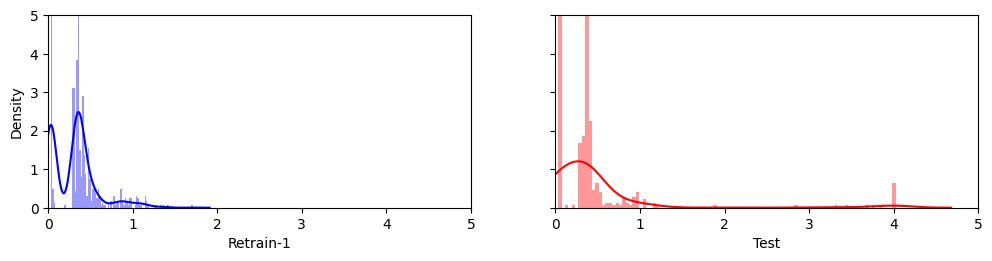

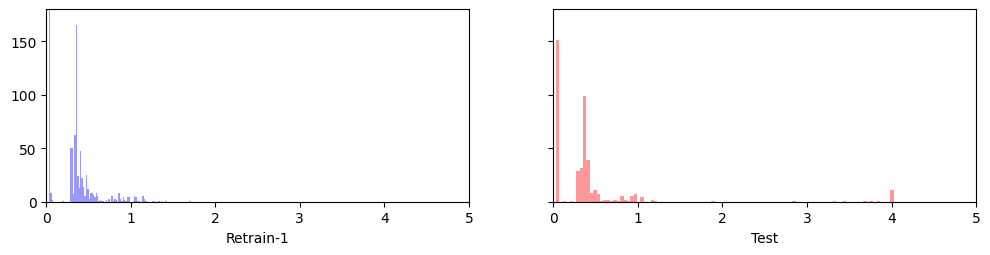

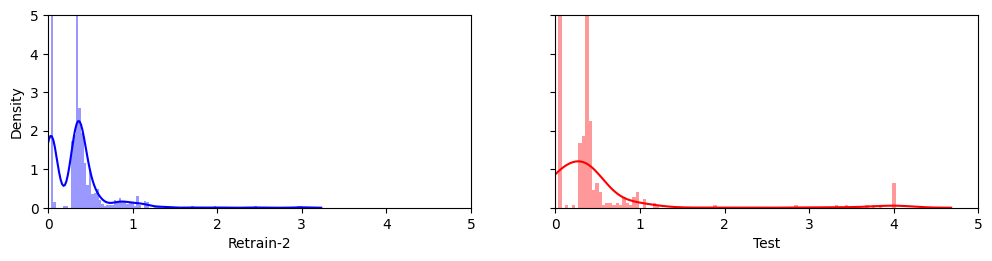

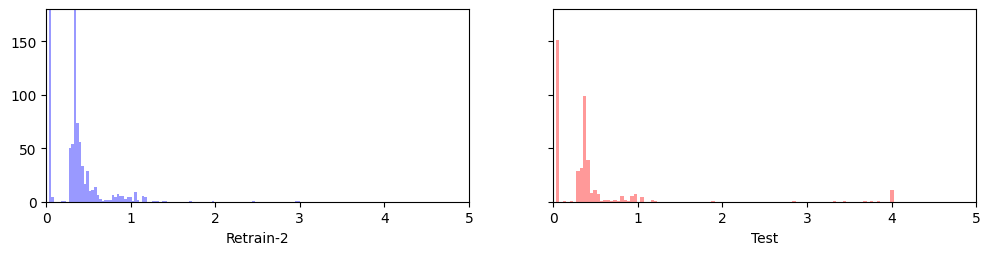

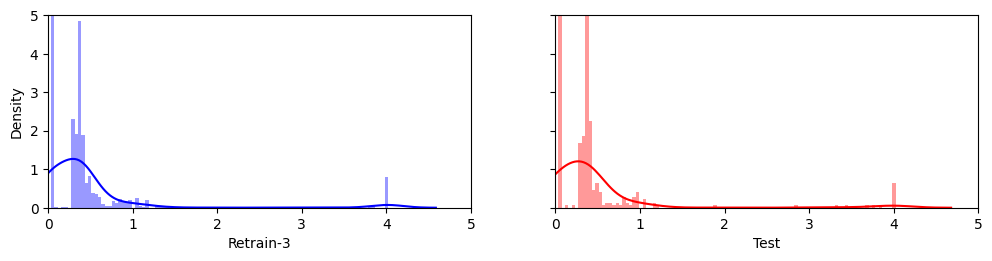

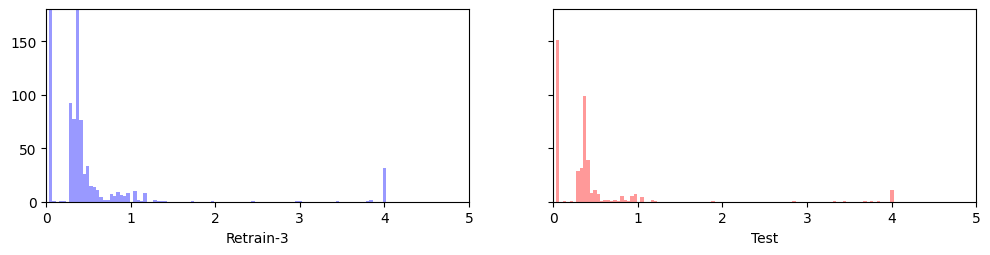

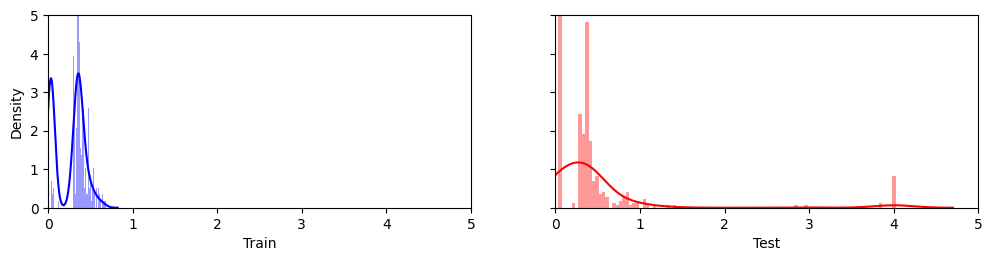

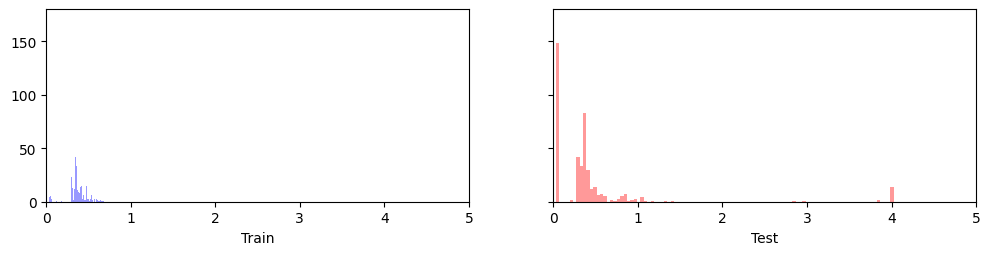

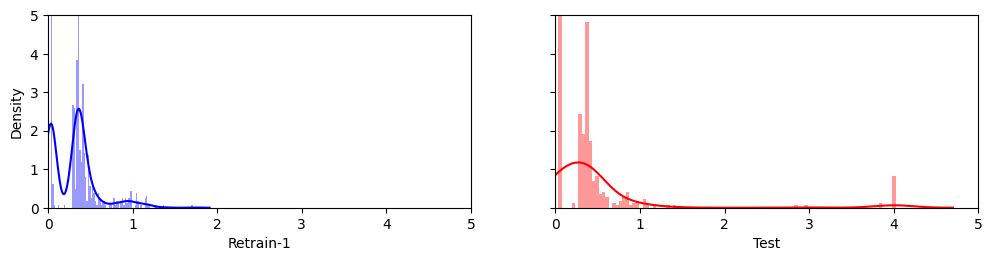

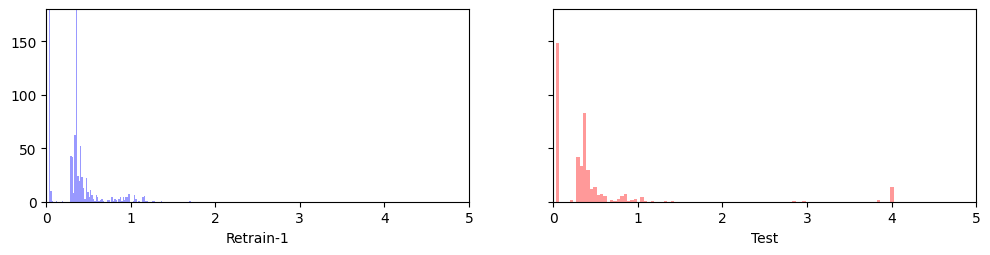

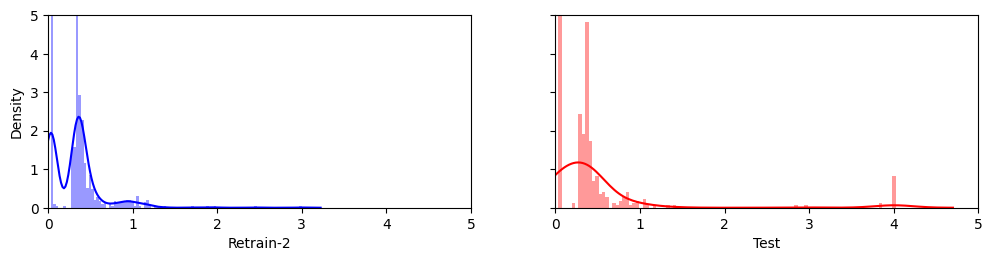

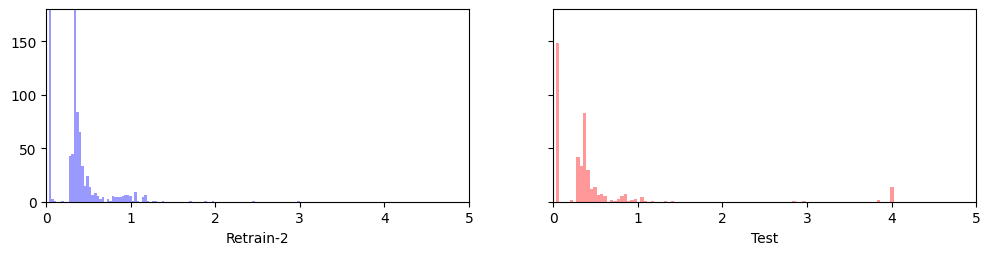

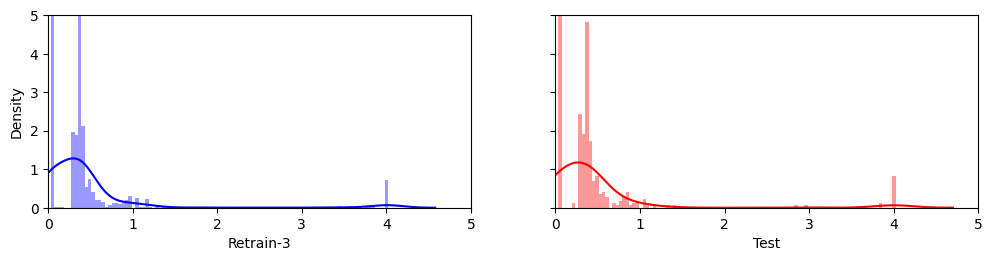

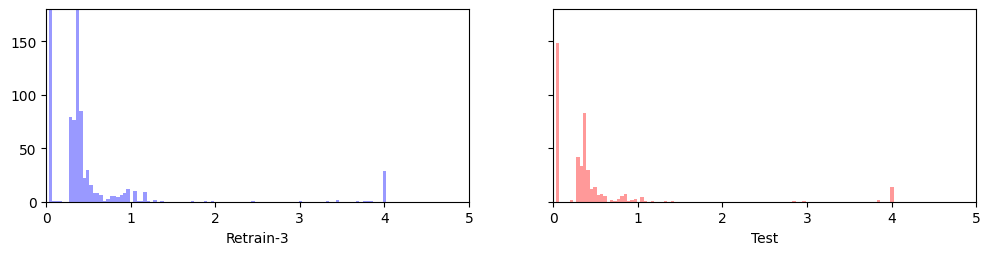

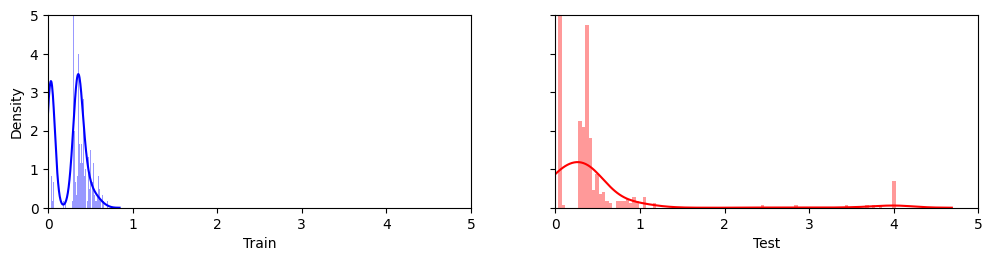

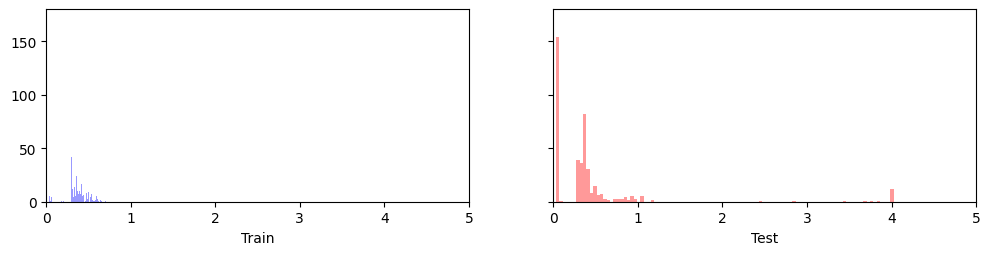

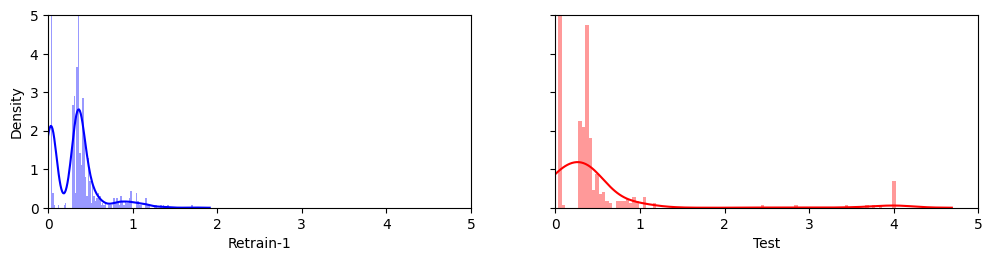

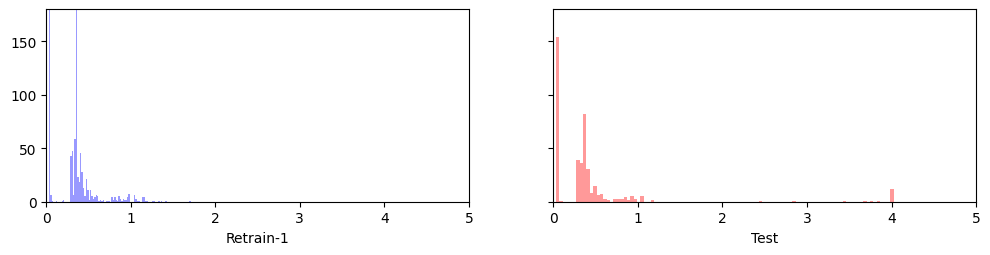

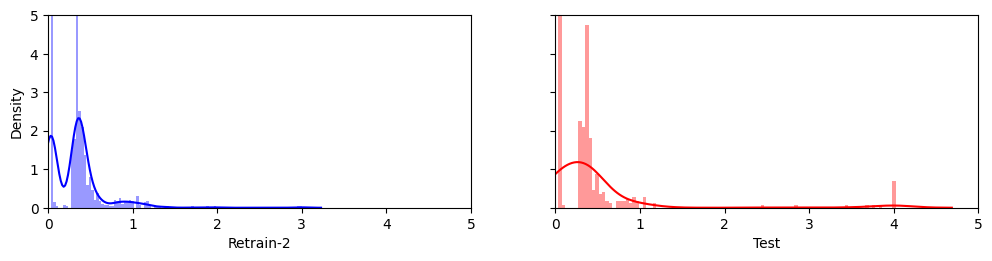

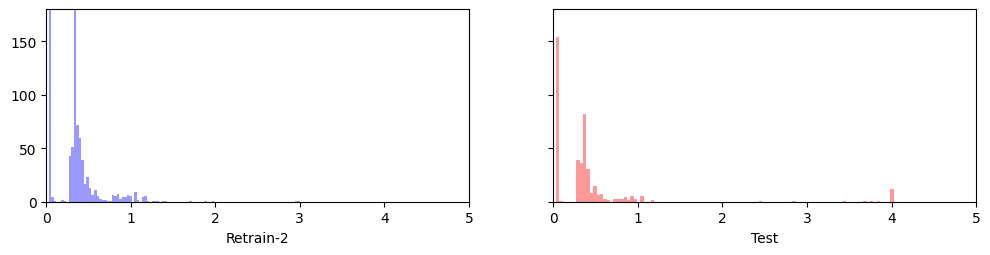

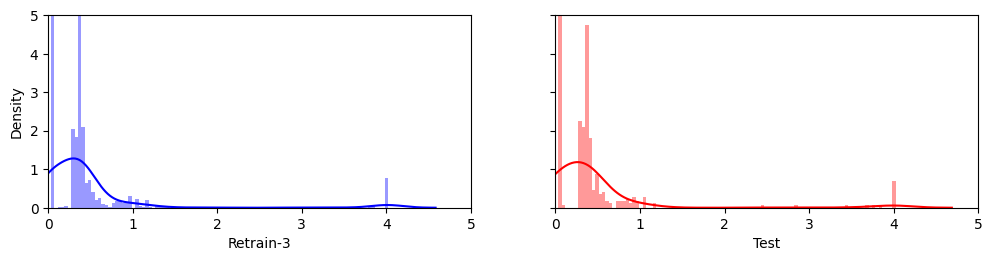

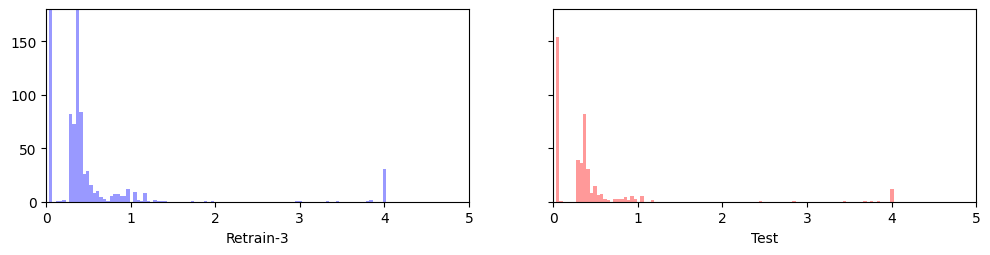

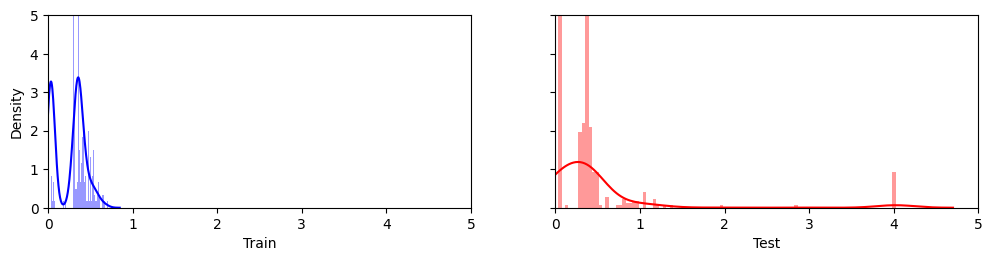

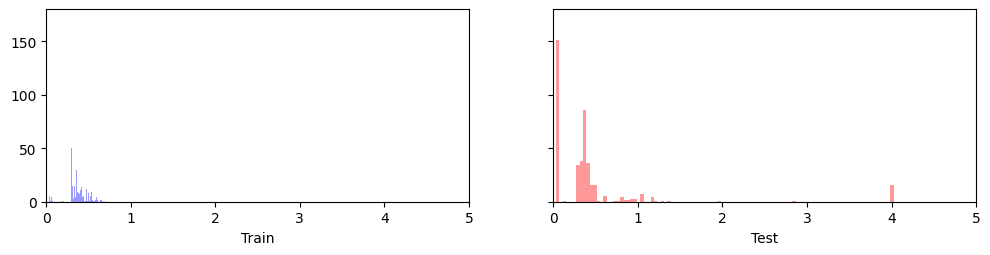

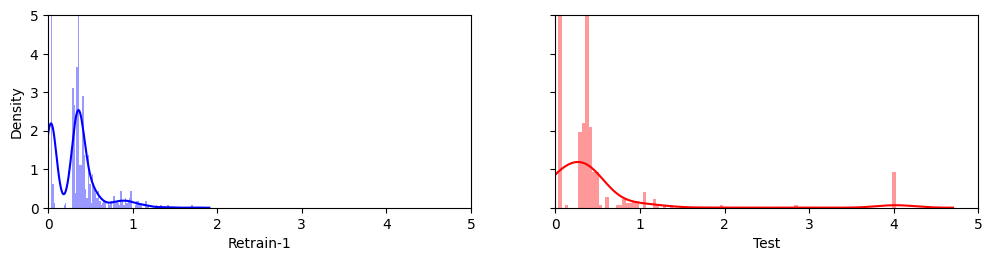

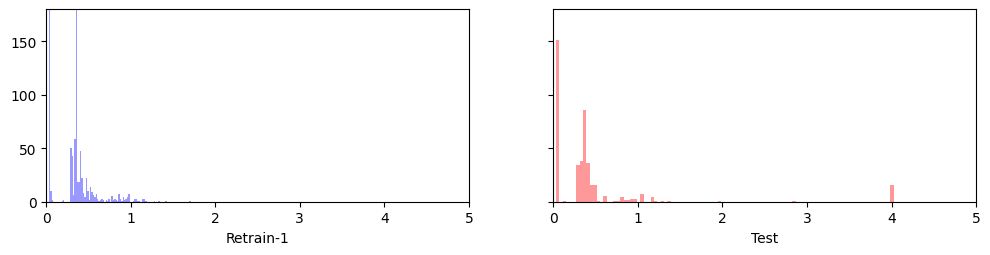

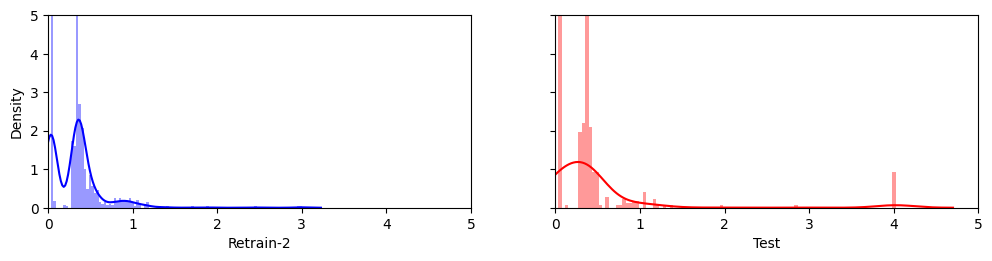

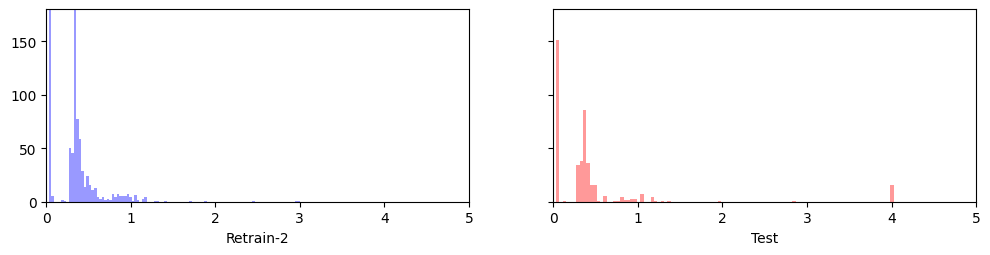

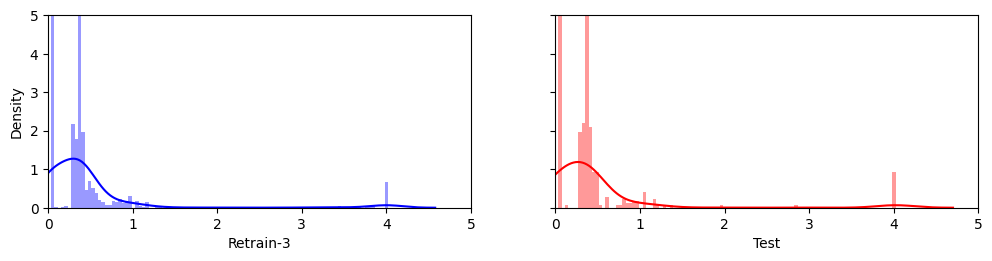

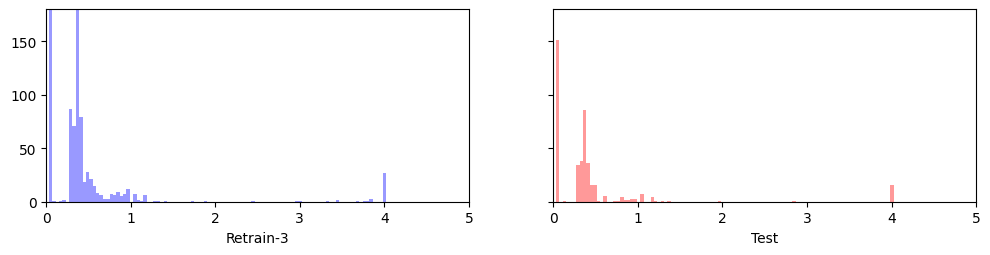

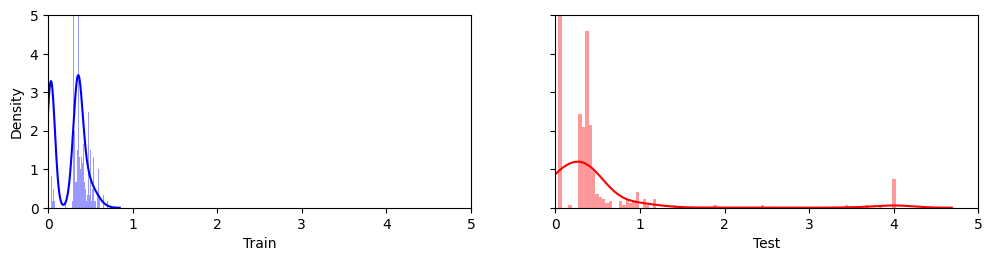

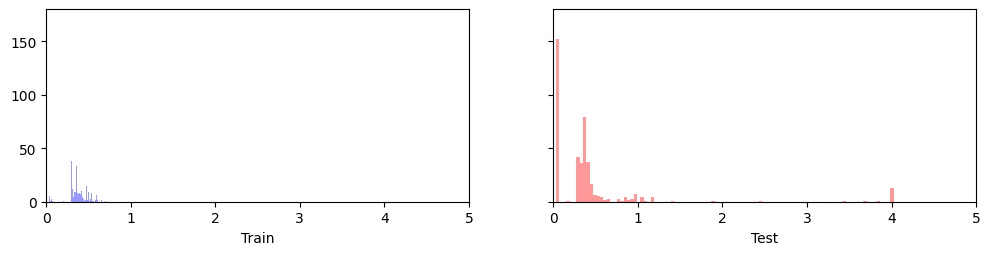

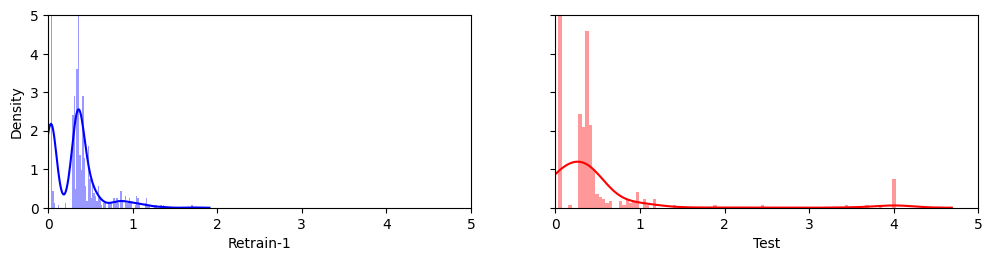

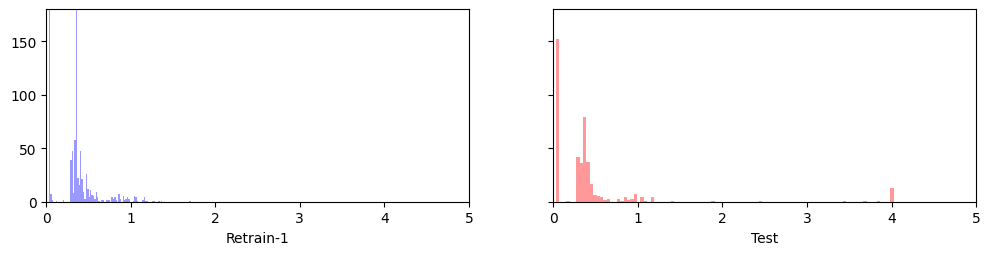

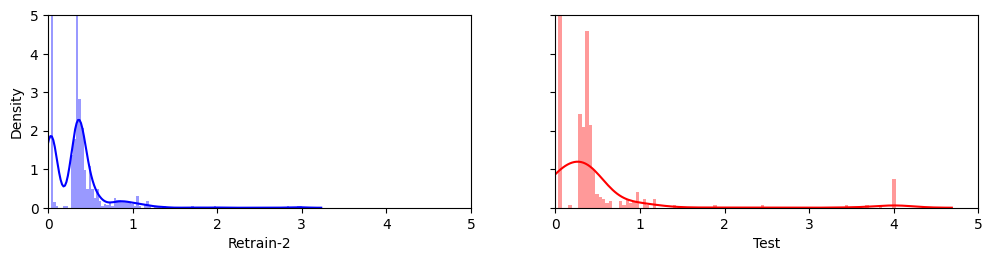

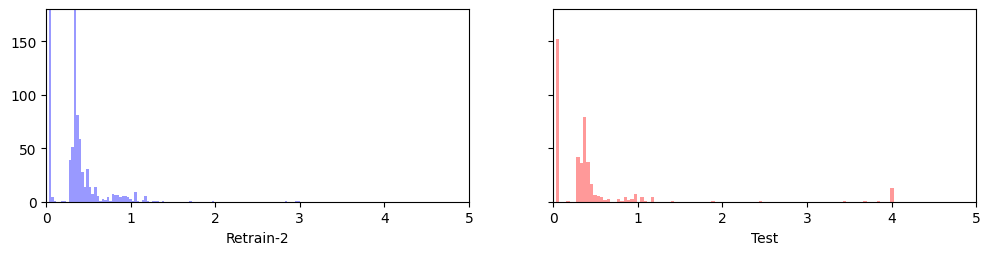

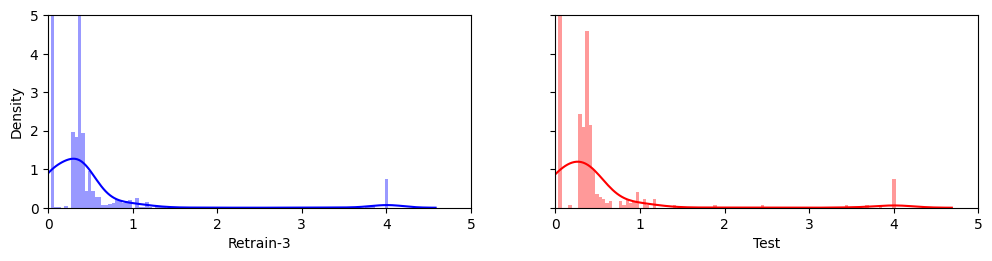

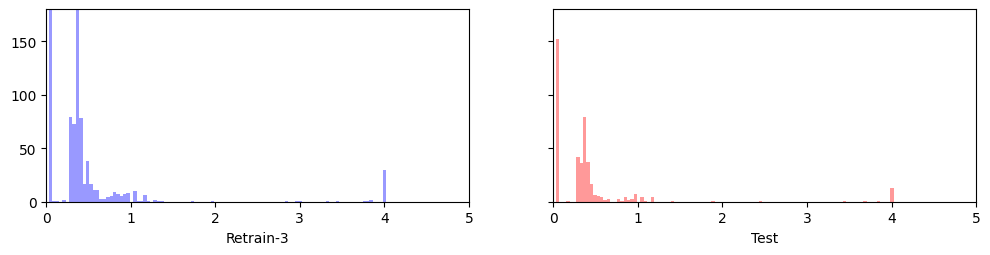

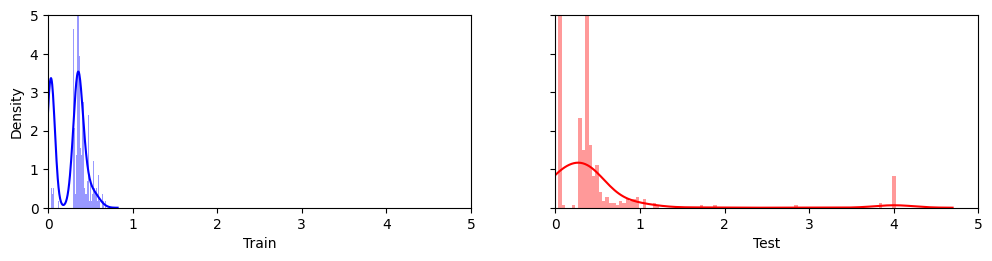

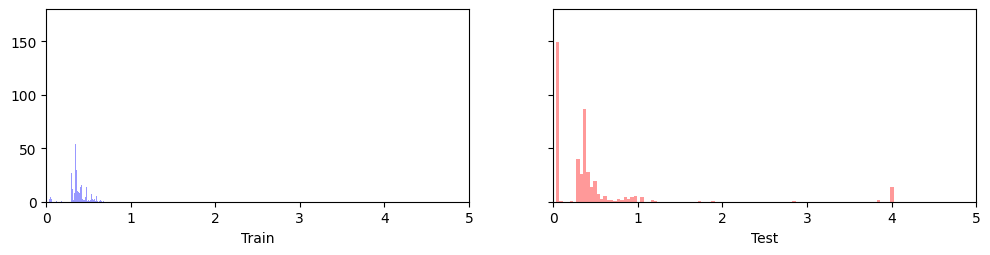

In [ ]:
# Initialize KLD arrays
kl_divergenceALL_T_T1 = []
kl_divergenceALL_RT_T2 = []
kl_featuresALL_T_T1 = []
kl_featuresALL_RT_T2 = []

for i in range(1, 31):
    numIter = i
    # tran classifier
    gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP = assignSample_trainClassifier(numIter)

    #print("itemID --- FUNCTION = ", str(numIter))
    # create retrain set and retrain classifier
    createRetrainSet(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP, numIter)


In [ ]:
#  COMPUTE COUNTS, PERFORMANCE, KLD
# SHow counts and Performance indicators

len_exp = len(df_CM["Method"].unique())
experiments = df_CM["Method"].unique()


for j in range (1, len_exp+1):
    experimentID = experiments[j-1]
                
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    getCounts(df_Counts, experimentID)
    getPerformance(df_CM, experimentID)
    getOoDScoreRange(df_OodRange, experimentID)
    

    # Initialize KLD arrays
    kl_divergenceALL_T_T1 = []
    kl_divergenceALL_RT_T2 = []
    kl_featuresALL_T_T1 = []
    kl_featuresALL_RT_T2 = []

    # Compute average for KLD features
    # 'Experiment1_0' - is the original training/testing -- to compare all experiments with
    kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2 = avgKLDbyFeature('Experiment1_0', experimentID, "All")
    kl_divergenceALL_T_T1_ood, kl_divergenceALL_RT_T2_ood, kl_featuresALL_T_T1_ood, kl_featuresALL_RT_T2_ood = avgKLDbyFeature('Experiment1_0', experimentID, "OOD")

    # KLD Cumulative Graph
    KLD_cummulativeGraph(kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2)

    #KLD CI
    getKLDRange(experimentID, "All")
    getKLDRange(experimentID, "OOD")
    
    print(" ")
    print(" ")


#### Significant Test - 2-tail (if Difference is Significant)

In [ ]:
Acc_test0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_test']
Acc_test1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_test']
Acc_test2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_test']
Acc_test3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_test']
Acc_test4 = df_CM.where((df_CM.Method== "Experiment1_4")).dropna()['Acc_test']


stat1, p_value1 = stats.ttest_ind(Acc_test0, Acc_test1)
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_test0, Acc_test2)
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_test0, Acc_test3)
sigDesc3 = sigPval(p_value3)
stat4, p_value4 = stats.ttest_ind(Acc_test0, Acc_test4)
sigDesc4 = sigPval(p_value4)

print("Test - Satt. Sig.")
print('ACC - Test-Baseline and Test 10: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Test-Baseline and Test 20: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Test-Baseline and Test 30: p_value=%.4f - %s' % (p_value3, sigDesc3))
print('ACC - Test-Baseline and Test 40: p_value=%.4f - %s' % (p_value4, sigDesc4))

#### Significant Test - 1-tail -- TRAIN and TEST -- (if Difference is sig. more than what you are comparing it with)

In [ ]:
# TEST
Acc_test0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_test']
Acc_test1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_test']
Acc_test2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_test']
Acc_test3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_test']

# test0 with all others
#ttest_1samp
stat1, p_value1 = stats.ttest_ind(Acc_test0, Acc_test1, alternative='less')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_test0, Acc_test2, alternative='less')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_test0, Acc_test3, alternative='less')
sigDesc3 = sigPval(p_value3)

# between tests 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(Acc_test1, Acc_test2, alternative='less')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(Acc_test2, Acc_test3, alternative='less')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TEST")
print("Test 1, 2, 3, 4 > Test 0 --- Sat. Sig. Greater?")
print('ACC - Test 0 and Test 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Test 0 and Test 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Test 0 and Test 3: p_value=%.4f - %s' % (p_value3, sigDesc3))

print(" ")
print("Test 1<2<3<4  --- Sat. Sig. Greater?")
print('ACC - Test 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('ACC - Test 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# TRAIN
Acc_train0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_train']
Acc_train1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_retrain']
Acc_train2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_retrain']
Acc_train3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_retrain']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(Acc_train0, Acc_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_train0, Acc_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_train0, Acc_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(Acc_train1, Acc_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(Acc_train2, Acc_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('ACC - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))

print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('ACC - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('ACC - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# KLD - All samples
kld_train0 = df_KLD.where((df_KLD['Method'] == "Experiment1_0") & (df_KLD['Types'] == "All")).dropna()['KLD_t_t']
kld_train1 = df_KLD.where((df_KLD['Method'] == "Experiment1_1") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']
kld_train2 = df_KLD.where((df_KLD['Method'] == "Experiment1_2") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']
kld_train3 = df_KLD.where((df_KLD['Method'] == "Experiment1_3") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(kld_train0, kld_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(kld_train0, kld_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(kld_train0, kld_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(kld_train1, kld_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(kld_train2, kld_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('kld - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('kld - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('kld - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))


print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('kld - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('kld - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# KLD - All samples
kld_train0 = df_KLD.where((df_KLD['Method'] == "Experiment1_0") & (df_KLD['Types'] == "OOD")).dropna()['KLD_t_t']
kld_train1 = df_KLD.where((df_KLD['Method'] == "Experiment1_1") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']
kld_train2 = df_KLD.where((df_KLD['Method'] == "Experiment1_2") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']
kld_train3 = df_KLD.where((df_KLD['Method'] == "Experiment1_3") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(kld_train0, kld_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(kld_train0, kld_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(kld_train0, kld_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(kld_train1, kld_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(kld_train2, kld_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('kld - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('kld - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('kld - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))


print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('kld - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('kld - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

### CORR for other DF

In [ ]:
stats.pointbiserialr(data_io.SuperscribedDiameter, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Solidity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SecondMoment, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Roughness, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MinIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MaxIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MeanIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SDIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MinIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MaxIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MeanIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SDIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.IntensityDifference, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov3, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov4, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov5, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_0_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_0_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_0_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_1_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_1_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Homogeneity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_2_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_3_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Contrast, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Correlation, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Inversevariance, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Sumaverage, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Variance, data_io.d_Malignancy)

In [ ]:
# Train the Random Forest model and measure time taken
model, training_time = train_random_forest(X, y)
print("Training time:", training_time, "seconds")

# Measure CPU usage
cpu_usage = psutil.cpu_percent()
print("CPU Usage:", cpu_usage, "%")

# Measure GPU usage
gpu_usage = measure_gpu_usage()
print("GPU Usage:", gpu_usage, "%")